In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation, Normalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention, Subtract
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


59

In [3]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [4]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [5]:
new_channels = []
for i in range(32):
  new_channels.append(i)

In [6]:
def simple_2D_CNN(x):   
  y = AvgPool2D(pool_size=(1,256))(x)
  y = Flatten()(y)
  y = Dense(4,activation='tanh') (y)
  y = Dense(32,activation='softmax') (y)
  x = Multiply()([x, tf.expand_dims(tf.expand_dims(y, axis=2), axis=2)])
  x = Conv2D(filters=16, kernel_size=(5,5), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(2,2))(x)
  x = Dropout(0.2)(x)
  x = Conv2D(filters=32, kernel_size=(7,7), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(2,2))(x)
  x = Dropout(0.2)(x)
  x = Conv2D(filters=64, kernel_size=(9,9), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Flatten()(x)
  x = Dense(256, activation='tanh')(x)
  x = Dropout(0.4)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.4)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model(): 
  input_shape = (32, 256, 1) 
  a = Input(input_shape) 
  out = simple_2D_CNN(a) 
  model = Model(a, out) 
  opt = keras.optimizers.Adam(learning_rate=1e-04) 
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt) 
  return model 
model = get_model() 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 32, 1, 1)    0           ['input_1[0][0]']                
 ing2D)                                                                                           
                                                                                                  
 flatten (Flatten)              (None, 32)           0           ['average_pooling2d[0][0]']      
                                                                                              

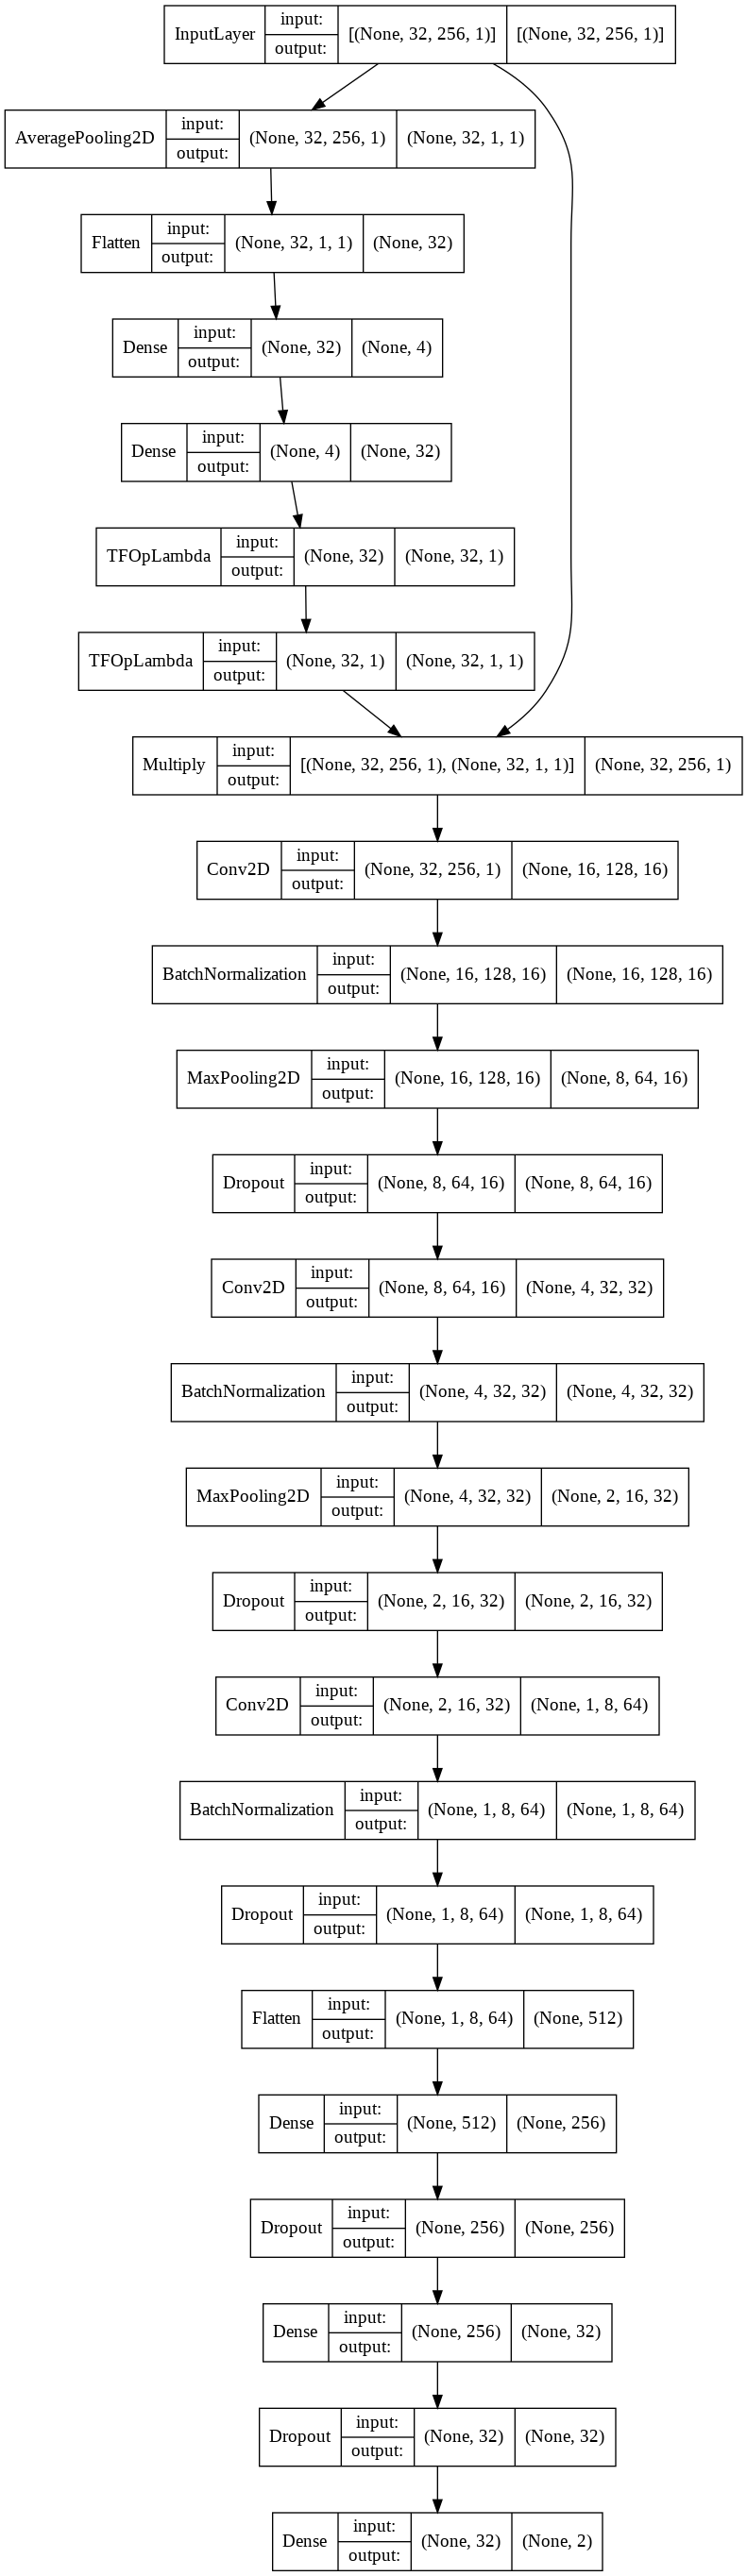

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [8]:
batch_size = 64
epochs = 100
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

7656

In [9]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Subject 13**

In [10]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(13,14):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.13
(1200, 32, 256, 1)
(1200,) (660,) (540,)
(1200,) (180,) (1020,)


0

# **Valence**

In [11]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 11s 26ms/step - loss: 1.0305 - accuracy: 0.5267 - val_loss: 0.6899 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8233 - accuracy: 0.5113 - val_loss: 0.6782 - val_accuracy: 0.6389
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7559 - accuracy: 0.5432 - val_loss: 0.6904 - val_accuracy: 0.4722
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7466 - accuracy: 0.5700 - val_loss: 0.7387 - val_accuracy: 0.4722
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7551 - accuracy: 0.5473 - val_loss: 0.8140 - val_accuracy: 0.4722
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7216 - accuracy: 0.5802 - val_loss: 0.8664 - val_accuracy: 0.4722
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7104 - accuracy: 0.5700 - val_loss: 0.8918 - val_accuracy:

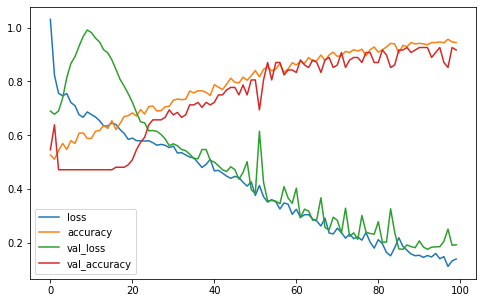

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9044 - accuracy: 0.5185 - val_loss: 0.6878 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8374 - accuracy: 0.5453 - val_loss: 0.6696 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7551 - accuracy: 0.5514 - val_loss: 0.6642 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7382 - accuracy: 0.5802 - val_loss: 0.6665 - val_accuracy: 0.6111
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7503 - accuracy: 0.5442 - val_loss: 0.6732 - val_accuracy: 0.6111
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7069 - accuracy: 0.5874 - val_loss: 0.6794 - val_accuracy: 0.6111
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6907 - accuracy: 0.5957 - val_loss: 0.6924 - val_accuracy:

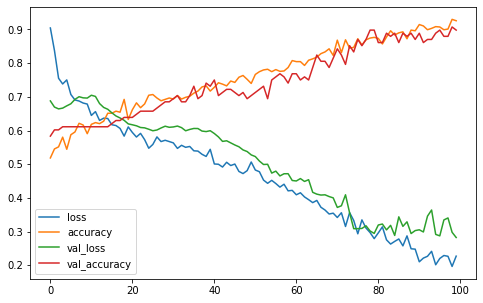

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.8728 - accuracy: 0.4979 - val_loss: 0.6882 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7945 - accuracy: 0.5340 - val_loss: 0.6744 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7655 - accuracy: 0.5720 - val_loss: 0.6679 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7200 - accuracy: 0.5823 - val_loss: 0.6736 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7188 - accuracy: 0.5864 - val_loss: 0.6965 - val_accuracy: 0.5741
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7342 - accuracy: 0.5576 - val_loss: 0.7237 - val_accuracy: 0.5741
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6690 - accuracy: 0.6008 - val_loss: 0.7484 - val_accuracy: 

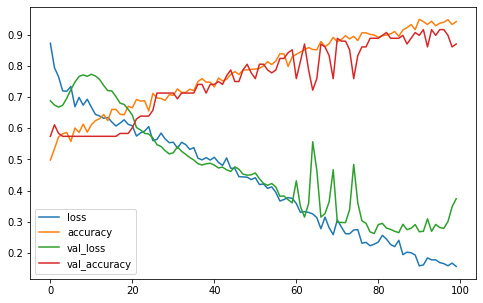

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9399 - accuracy: 0.5062 - val_loss: 0.6855 - val_accuracy: 0.6481
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8547 - accuracy: 0.5082 - val_loss: 0.6900 - val_accuracy: 0.5556
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7755 - accuracy: 0.5607 - val_loss: 0.6911 - val_accuracy: 0.4815
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7737 - accuracy: 0.5525 - val_loss: 0.6921 - val_accuracy: 0.4722
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7402 - accuracy: 0.5700 - val_loss: 0.6945 - val_accuracy: 0.4722
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7430 - accuracy: 0.5432 - val_loss: 0.6966 - val_accuracy: 0.4722
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7314 - accuracy: 0.5442 - val_loss: 0.6963 - val_accuracy: 

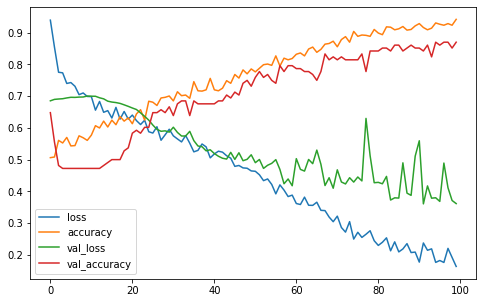

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 1.0963 - accuracy: 0.5134 - val_loss: 0.6956 - val_accuracy: 0.4259
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8484 - accuracy: 0.5051 - val_loss: 0.6955 - val_accuracy: 0.4444
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8374 - accuracy: 0.5113 - val_loss: 0.6913 - val_accuracy: 0.4907
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7926 - accuracy: 0.5041 - val_loss: 0.6860 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7603 - accuracy: 0.5473 - val_loss: 0.6786 - val_accuracy: 0.5648
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7241 - accuracy: 0.5422 - val_loss: 0.6722 - val_accuracy: 0.5370
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7022 - accuracy: 0.5689 - val_loss: 0.6679 - val_accuracy: 

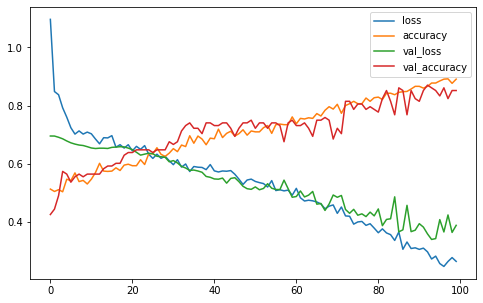

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0720 - accuracy: 0.4712 - val_loss: 0.6883 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9540 - accuracy: 0.4877 - val_loss: 0.6834 - val_accuracy: 0.5926
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8838 - accuracy: 0.5267 - val_loss: 0.6809 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8345 - accuracy: 0.5319 - val_loss: 0.6787 - val_accuracy: 0.5833
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7607 - accuracy: 0.5586 - val_loss: 0.6776 - val_accuracy: 0.5833
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7609 - accuracy: 0.5586 - val_loss: 0.6774 - val_accuracy: 0.5833
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7280 - accuracy: 0.5720 - val_loss: 0.6785 - val_accuracy: 

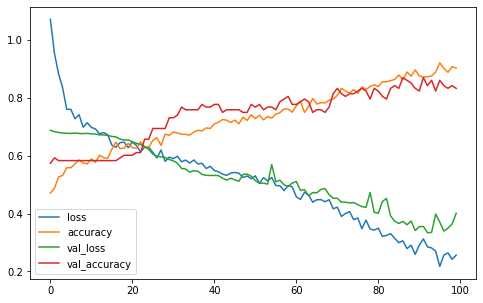

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9881 - accuracy: 0.5545 - val_loss: 0.7014 - val_accuracy: 0.4167
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9148 - accuracy: 0.5288 - val_loss: 0.6790 - val_accuracy: 0.5926
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8654 - accuracy: 0.5237 - val_loss: 0.6575 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8140 - accuracy: 0.5370 - val_loss: 0.6500 - val_accuracy: 0.6019
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7658 - accuracy: 0.5607 - val_loss: 0.6529 - val_accuracy: 0.6019
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7427 - accuracy: 0.5607 - val_loss: 0.6608 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7488 - accuracy: 0.5741 - val_loss: 0.6677 - val_accuracy

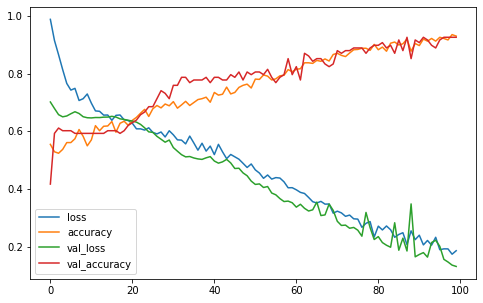

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9431 - accuracy: 0.5041 - val_loss: 0.6900 - val_accuracy: 0.5278
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8663 - accuracy: 0.5082 - val_loss: 0.6793 - val_accuracy: 0.6204
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7941 - accuracy: 0.5453 - val_loss: 0.6750 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7663 - accuracy: 0.5432 - val_loss: 0.6786 - val_accuracy: 0.5648
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7480 - accuracy: 0.5453 - val_loss: 0.6836 - val_accuracy: 0.5648
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7366 - accuracy: 0.5607 - val_loss: 0.6908 - val_accuracy: 0.5556
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7390 - accuracy: 0.5463 - val_loss: 0.6922 - val_accur

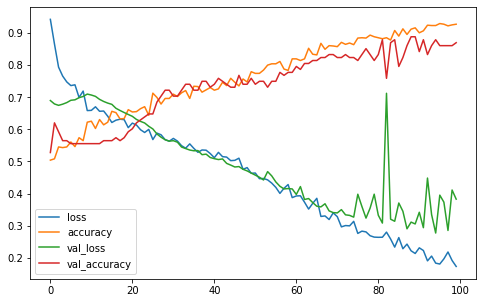

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9284 - accuracy: 0.4887 - val_loss: 0.6924 - val_accuracy: 0.5093
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7851 - accuracy: 0.5679 - val_loss: 0.6925 - val_accuracy: 0.5185
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8264 - accuracy: 0.5309 - val_loss: 0.6952 - val_accuracy: 0.5093
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8003 - accuracy: 0.5360 - val_loss: 0.7058 - val_accuracy: 0.5093
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7294 - accuracy: 0.5597 - val_loss: 0.7281 - val_accuracy: 0.5093
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7592 - accuracy: 0.5340 - val_loss: 0.7624 - val_accuracy: 0.5093
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7144 - accuracy: 0.5905 - val_loss: 0.7739 - val_accur

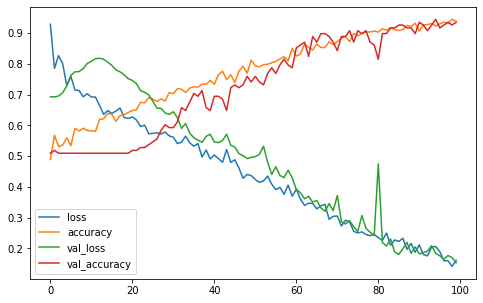

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9627 - accuracy: 0.5072 - val_loss: 0.6954 - val_accuracy: 0.4722
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8520 - accuracy: 0.4907 - val_loss: 0.6876 - val_accuracy: 0.5463
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8291 - accuracy: 0.5329 - val_loss: 0.6819 - val_accuracy: 0.5741
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7544 - accuracy: 0.5412 - val_loss: 0.6977 - val_accuracy: 0.5463
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7475 - accuracy: 0.5545 - val_loss: 0.7343 - val_accuracy: 0.5370
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7188 - accuracy: 0.5813 - val_loss: 0.7702 - val_accuracy: 0.5370
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7107 - accuracy: 0.5669 - val_loss: 0.7827 - val_accurac

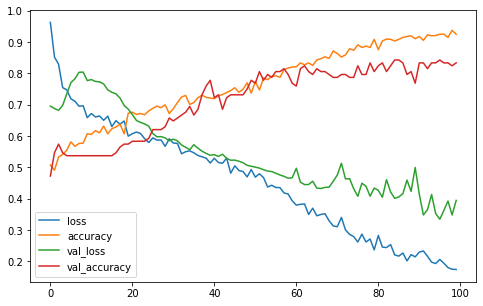

In [12]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.8783333361148834
F1_Score  : 0.8739062833040151


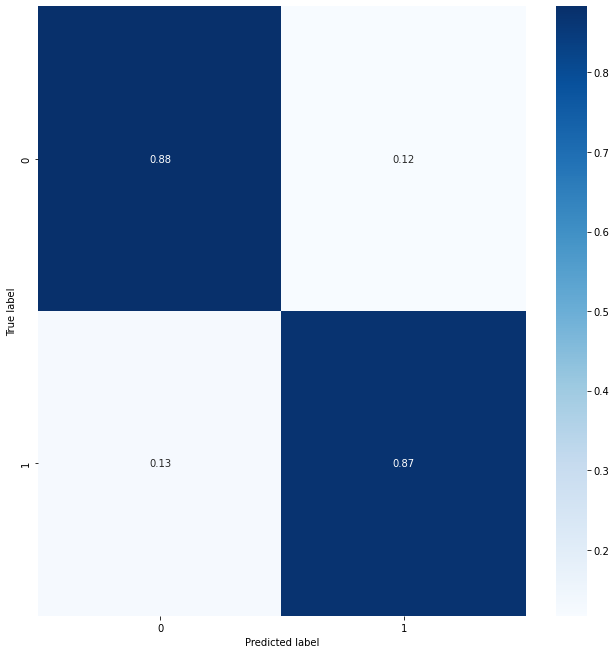

In [13]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [14]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9357 - accuracy: 0.4763 - val_loss: 0.6781 - val_accuracy: 0.6944
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9213 - accuracy: 0.5278 - val_loss: 0.6855 - val_accuracy: 0.5833
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8414 - accuracy: 0.5309 - val_loss: 0.7096 - val_accuracy: 0.2963
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8460 - accuracy: 0.5123 - val_loss: 0.7471 - val_accuracy: 0.1204
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8432 - accuracy: 0.5082 - val_loss: 0.7705 - val_accuracy: 0.1019
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7763 - accuracy: 0.5103 - val_loss: 0.7830 - val_accuracy: 0.1019
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7287 - accuracy: 0.5473 - val_loss: 0.8060 - val_accuracy:

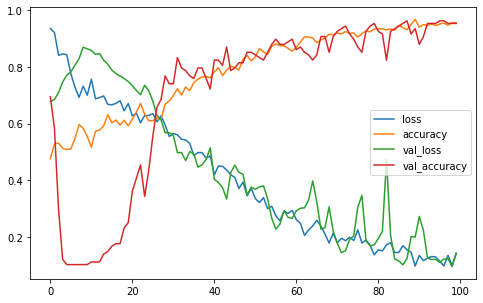

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8894 - accuracy: 0.5319 - val_loss: 0.6900 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8430 - accuracy: 0.5175 - val_loss: 0.7052 - val_accuracy: 0.2685
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8280 - accuracy: 0.4846 - val_loss: 0.7333 - val_accuracy: 0.0926
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7683 - accuracy: 0.5010 - val_loss: 0.7518 - val_accuracy: 0.0926
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7626 - accuracy: 0.4979 - val_loss: 0.7663 - val_accuracy: 0.0926
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7448 - accuracy: 0.4979 - val_loss: 0.7924 - val_accuracy: 0.0833
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7038 - accuracy: 0.5093 - val_loss: 0.8091 - val_accuracy:

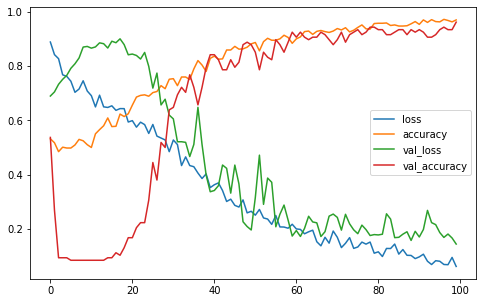

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9187 - accuracy: 0.4815 - val_loss: 0.6782 - val_accuracy: 0.7407
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9065 - accuracy: 0.5329 - val_loss: 0.6781 - val_accuracy: 0.7037
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8698 - accuracy: 0.5010 - val_loss: 0.6979 - val_accuracy: 0.4815
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7842 - accuracy: 0.5031 - val_loss: 0.7245 - val_accuracy: 0.2407
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7534 - accuracy: 0.5041 - val_loss: 0.7417 - val_accuracy: 0.2222
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7283 - accuracy: 0.5432 - val_loss: 0.7664 - val_accuracy: 0.2130
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7463 - accuracy: 0.5514 - val_loss: 0.8050 - val_accuracy: 

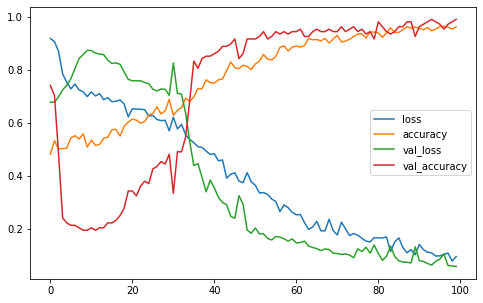

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0233 - accuracy: 0.5792 - val_loss: 0.7069 - val_accuracy: 0.2870
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8433 - accuracy: 0.5175 - val_loss: 0.7105 - val_accuracy: 0.2315
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8732 - accuracy: 0.5206 - val_loss: 0.7380 - val_accuracy: 0.1204
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8008 - accuracy: 0.5216 - val_loss: 0.7838 - val_accuracy: 0.1111
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7838 - accuracy: 0.5309 - val_loss: 0.8318 - val_accuracy: 0.1111
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7413 - accuracy: 0.5525 - val_loss: 0.8544 - val_accuracy: 0.1111
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7391 - accuracy: 0.5360 - val_loss: 0.8756 - val_accuracy:

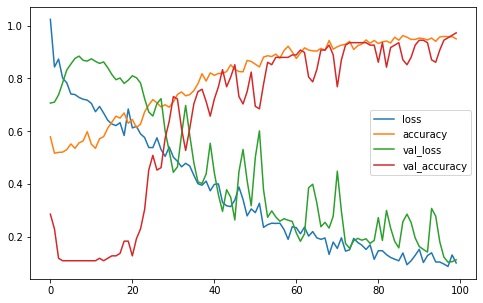

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9355 - accuracy: 0.5833 - val_loss: 0.6876 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.9365 - accuracy: 0.5751 - val_loss: 0.7103 - val_accuracy: 0.3148
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8186 - accuracy: 0.5782 - val_loss: 0.7508 - val_accuracy: 0.2130
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8390 - accuracy: 0.5658 - val_loss: 0.7778 - val_accuracy: 0.2130
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7195 - accuracy: 0.5730 - val_loss: 0.8057 - val_accuracy: 0.2130
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7435 - accuracy: 0.5802 - val_loss: 0.8171 - val_accuracy: 0.1944
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7250 - accuracy: 0.5936 - val_loss: 0.8328 - val_accuracy

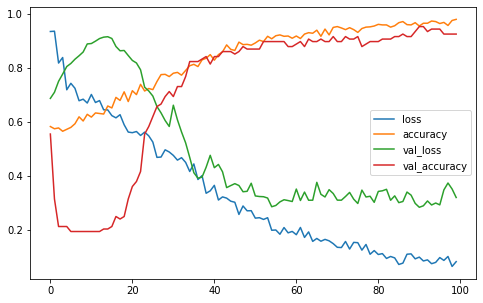

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8617 - accuracy: 0.4444 - val_loss: 0.6825 - val_accuracy: 0.7593
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8102 - accuracy: 0.4599 - val_loss: 0.6943 - val_accuracy: 0.4815
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7436 - accuracy: 0.5195 - val_loss: 0.7133 - val_accuracy: 0.2407
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7449 - accuracy: 0.5072 - val_loss: 0.7416 - val_accuracy: 0.1944
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7242 - accuracy: 0.5226 - val_loss: 0.7705 - val_accuracy: 0.1852
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7200 - accuracy: 0.5257 - val_loss: 0.7839 - val_accuracy: 0.1852
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7055 - accuracy: 0.5628 - val_loss: 0.8050 - val_accuracy:

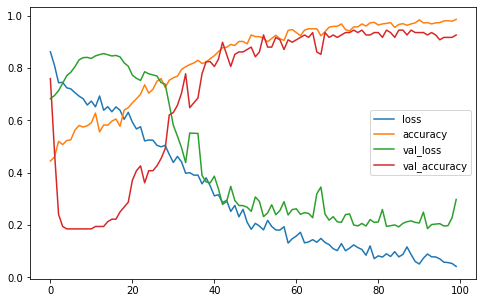

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9172 - accuracy: 0.5813 - val_loss: 0.6954 - val_accuracy: 0.4167
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9159 - accuracy: 0.5134 - val_loss: 0.7006 - val_accuracy: 0.3426
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8304 - accuracy: 0.5041 - val_loss: 0.7055 - val_accuracy: 0.3148
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7400 - accuracy: 0.5401 - val_loss: 0.7193 - val_accuracy: 0.2037
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7955 - accuracy: 0.5175 - val_loss: 0.7355 - val_accuracy: 0.2037
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7755 - accuracy: 0.4990 - val_loss: 0.7580 - val_accuracy: 0.2037
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7393 - accuracy: 0.5401 - val_loss: 0.7821 - val_accuracy

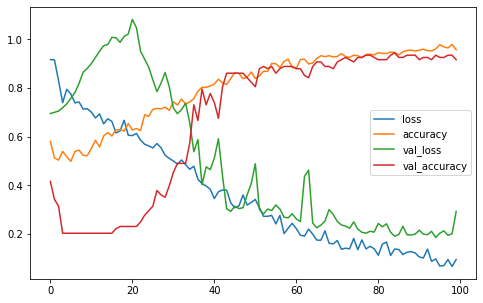

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8120 - accuracy: 0.4660 - val_loss: 0.6905 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7724 - accuracy: 0.5257 - val_loss: 0.6922 - val_accuracy: 0.5278
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7156 - accuracy: 0.5453 - val_loss: 0.6972 - val_accuracy: 0.4259
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7289 - accuracy: 0.5340 - val_loss: 0.7054 - val_accuracy: 0.3148
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6784 - accuracy: 0.5504 - val_loss: 0.7155 - val_accuracy: 0.2685
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7001 - accuracy: 0.5514 - val_loss: 0.7245 - val_accuracy: 0.2500
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6927 - accuracy: 0.5658 - val_loss: 0.7278 - val_accuracy:

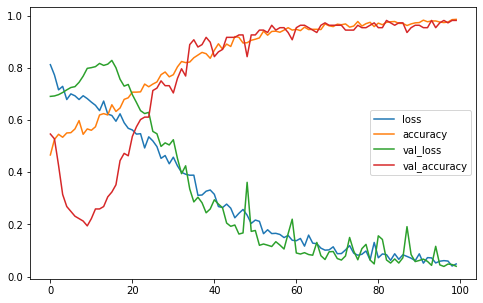

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9721 - accuracy: 0.5422 - val_loss: 0.6988 - val_accuracy: 0.3148
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7753 - accuracy: 0.4928 - val_loss: 0.7320 - val_accuracy: 0.1667
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7617 - accuracy: 0.5113 - val_loss: 0.7666 - val_accuracy: 0.1574
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7454 - accuracy: 0.5195 - val_loss: 0.8137 - val_accuracy: 0.1574
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7465 - accuracy: 0.5134 - val_loss: 0.8631 - val_accuracy: 0.1574
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6876 - accuracy: 0.5494 - val_loss: 0.9040 - val_accuracy: 0.1574
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7574 - accuracy: 0.5267 - val_loss: 0.9227 - val_accu

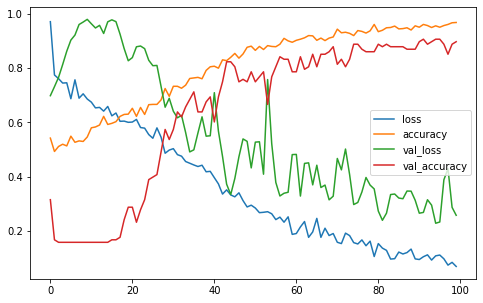

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9827 - accuracy: 0.5237 - val_loss: 0.6911 - val_accuracy: 0.4815
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9218 - accuracy: 0.5195 - val_loss: 0.7118 - val_accuracy: 0.3148
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8297 - accuracy: 0.5576 - val_loss: 0.7254 - val_accuracy: 0.2500
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8595 - accuracy: 0.5391 - val_loss: 0.7554 - val_accuracy: 0.2037
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8378 - accuracy: 0.5319 - val_loss: 0.7866 - val_accuracy: 0.1759
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8220 - accuracy: 0.5422 - val_loss: 0.7936 - val_accuracy: 0.1667
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7666 - accuracy: 0.5432 - val_loss: 0.8113 - val_accur

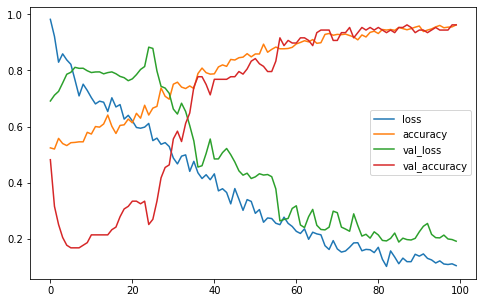

In [15]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.948333328962326
F1_Score  : 0.8725080802613912


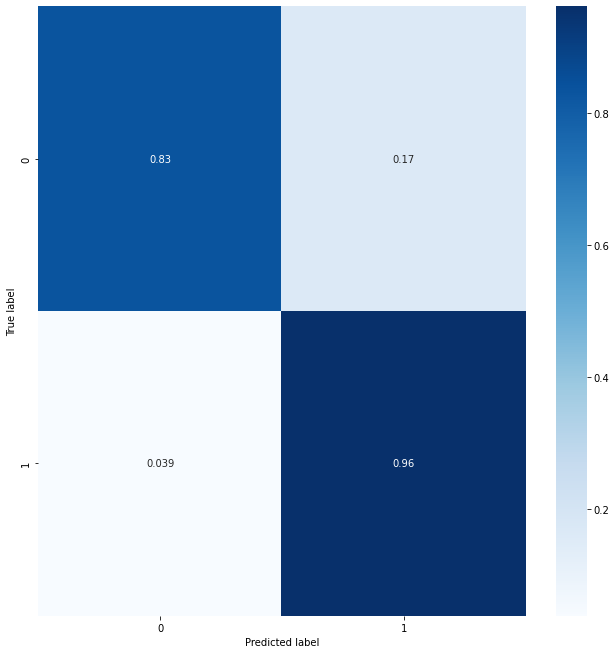

In [16]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 14**

In [17]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(14,15):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.14
(1200, 32, 256, 1)
(1200,) (600,) (600,)
(1200,) (390,) (810,)


3750

# **Valence**

In [18]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.1037 - accuracy: 0.5103 - val_loss: 0.6764 - val_accuracy: 0.6852
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8820 - accuracy: 0.5216 - val_loss: 0.6920 - val_accuracy: 0.4815
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8295 - accuracy: 0.5072 - val_loss: 0.7008 - val_accuracy: 0.4444
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7910 - accuracy: 0.5638 - val_loss: 0.7013 - val_accuracy: 0.4259
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7702 - accuracy: 0.5453 - val_loss: 0.7023 - val_accuracy: 0.4444
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7807 - accuracy: 0.5453 - val_loss: 0.7023 - val_accuracy: 0.4259
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7125 - accuracy: 0.5669 - val_loss: 0.7041 - val_accuracy:

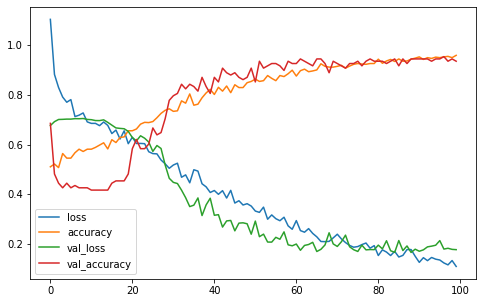

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.8782 - accuracy: 0.5278 - val_loss: 0.7169 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8577 - accuracy: 0.5401 - val_loss: 0.6933 - val_accuracy: 0.5556
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7644 - accuracy: 0.5566 - val_loss: 0.6811 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7648 - accuracy: 0.5658 - val_loss: 0.6760 - val_accuracy: 0.5833
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7283 - accuracy: 0.5761 - val_loss: 0.6636 - val_accuracy: 0.6019
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6984 - accuracy: 0.5988 - val_loss: 0.6571 - val_accuracy: 0.6111
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6970 - accuracy: 0.6204 - val_loss: 0.6511 - val_accuracy: 

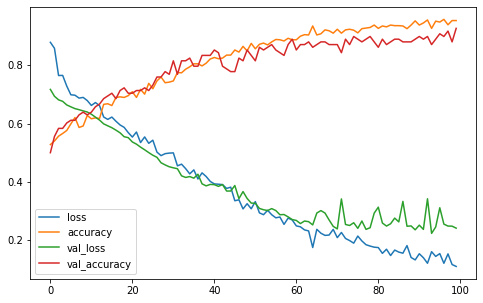

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9960 - accuracy: 0.4794 - val_loss: 0.6884 - val_accuracy: 0.5278
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8251 - accuracy: 0.5401 - val_loss: 0.6879 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8444 - accuracy: 0.5195 - val_loss: 0.6874 - val_accuracy: 0.5185
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7542 - accuracy: 0.5535 - val_loss: 0.6828 - val_accuracy: 0.5463
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7124 - accuracy: 0.5874 - val_loss: 0.6782 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7381 - accuracy: 0.5638 - val_loss: 0.6727 - val_accuracy: 0.5648
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7123 - accuracy: 0.5926 - val_loss: 0.6702 - val_accuracy: 

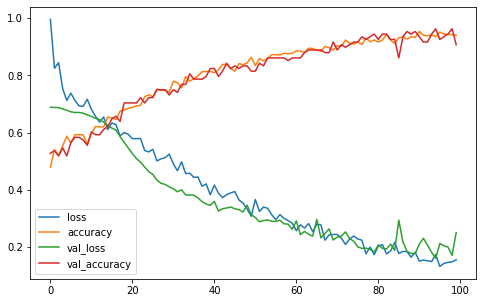

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8474 - accuracy: 0.5391 - val_loss: 0.7011 - val_accuracy: 0.4352
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8120 - accuracy: 0.5216 - val_loss: 0.6830 - val_accuracy: 0.5741
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7605 - accuracy: 0.5525 - val_loss: 0.6839 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7541 - accuracy: 0.5206 - val_loss: 0.6856 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7195 - accuracy: 0.5597 - val_loss: 0.6840 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6816 - accuracy: 0.5864 - val_loss: 0.6796 - val_accuracy: 0.6481
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7130 - accuracy: 0.5833 - val_loss: 0.6818 - val_accuracy:

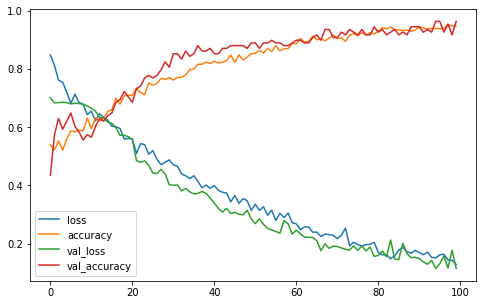

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0642 - accuracy: 0.5113 - val_loss: 0.7070 - val_accuracy: 0.5093
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8337 - accuracy: 0.5535 - val_loss: 0.6834 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8180 - accuracy: 0.5267 - val_loss: 0.6724 - val_accuracy: 0.5463
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7946 - accuracy: 0.5247 - val_loss: 0.6663 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7399 - accuracy: 0.5761 - val_loss: 0.6624 - val_accuracy: 0.5741
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7352 - accuracy: 0.5741 - val_loss: 0.6594 - val_accuracy: 0.5648
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7101 - accuracy: 0.5700 - val_loss: 0.6570 - val_accuracy:

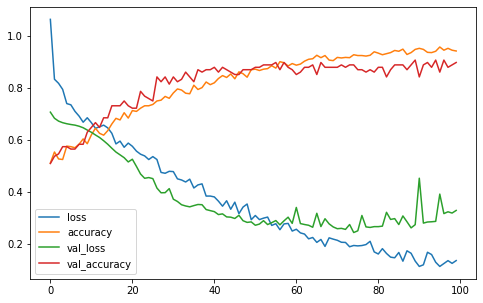

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9066 - accuracy: 0.5041 - val_loss: 0.6891 - val_accuracy: 0.5926
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8001 - accuracy: 0.5298 - val_loss: 0.6827 - val_accuracy: 0.5926
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7592 - accuracy: 0.5360 - val_loss: 0.6782 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7255 - accuracy: 0.5782 - val_loss: 0.6716 - val_accuracy: 0.6852
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7324 - accuracy: 0.5628 - val_loss: 0.6648 - val_accuracy: 0.6944
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7184 - accuracy: 0.5628 - val_loss: 0.6635 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6842 - accuracy: 0.5874 - val_loss: 0.6580 - val_accuracy:

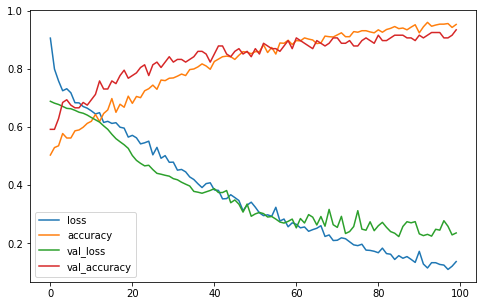

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8981 - accuracy: 0.5062 - val_loss: 0.6979 - val_accuracy: 0.5185
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8169 - accuracy: 0.5278 - val_loss: 0.6907 - val_accuracy: 0.5463
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7488 - accuracy: 0.5484 - val_loss: 0.6888 - val_accuracy: 0.5185
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7280 - accuracy: 0.5586 - val_loss: 0.6832 - val_accuracy: 0.5648
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7043 - accuracy: 0.5792 - val_loss: 0.6799 - val_accuracy: 0.5926
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6933 - accuracy: 0.5957 - val_loss: 0.6727 - val_accuracy: 0.5833
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6813 - accuracy: 0.6142 - val_loss: 0.6618 - val_accuracy

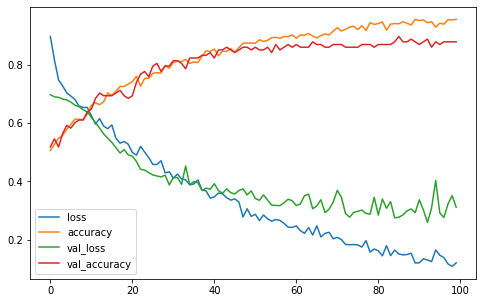

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8685 - accuracy: 0.5062 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7864 - accuracy: 0.5216 - val_loss: 0.6766 - val_accuracy: 0.5556
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7569 - accuracy: 0.5607 - val_loss: 0.6699 - val_accuracy: 0.5463
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7270 - accuracy: 0.5638 - val_loss: 0.6711 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7036 - accuracy: 0.5905 - val_loss: 0.6687 - val_accuracy: 0.5741
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6904 - accuracy: 0.5792 - val_loss: 0.6637 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7093 - accuracy: 0.5751 - val_loss: 0.6513 - val_accurac

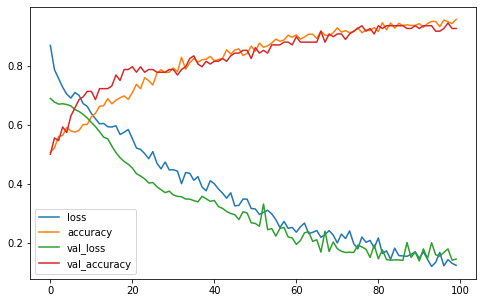

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8775 - accuracy: 0.5144 - val_loss: 0.6863 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8183 - accuracy: 0.5195 - val_loss: 0.6861 - val_accuracy: 0.5833
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7892 - accuracy: 0.4969 - val_loss: 0.6851 - val_accuracy: 0.5648
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7634 - accuracy: 0.5401 - val_loss: 0.6806 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7309 - accuracy: 0.5710 - val_loss: 0.6809 - val_accuracy: 0.5556
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7240 - accuracy: 0.5556 - val_loss: 0.6814 - val_accuracy: 0.5185
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7056 - accuracy: 0.5700 - val_loss: 0.6771 - val_accur

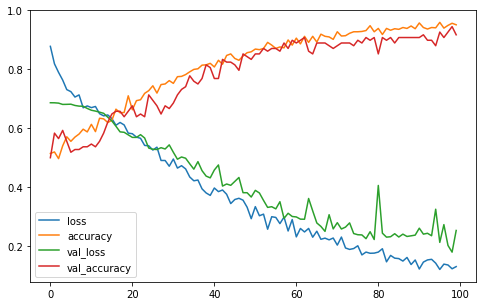

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9835 - accuracy: 0.5082 - val_loss: 0.6894 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8523 - accuracy: 0.5051 - val_loss: 0.6834 - val_accuracy: 0.5556
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7804 - accuracy: 0.5267 - val_loss: 0.6784 - val_accuracy: 0.5741
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7247 - accuracy: 0.5679 - val_loss: 0.6746 - val_accuracy: 0.6204
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7774 - accuracy: 0.5288 - val_loss: 0.6708 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7124 - accuracy: 0.5556 - val_loss: 0.6665 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7039 - accuracy: 0.5658 - val_loss: 0.6610 - val_accurac

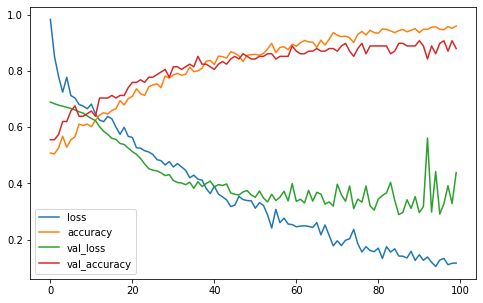

In [19]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9025000035762787
F1_Score  : 0.9023269645485422


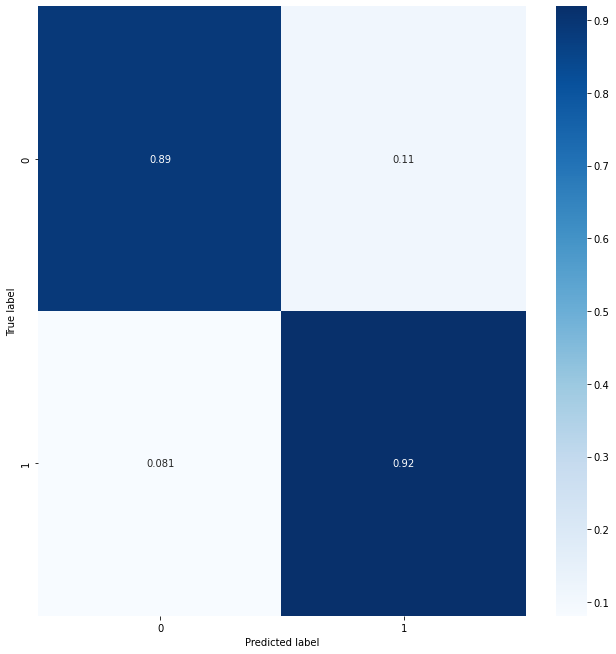

In [20]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [21]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9004 - accuracy: 0.6471 - val_loss: 0.6951 - val_accuracy: 0.4907
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7648 - accuracy: 0.6039 - val_loss: 0.6969 - val_accuracy: 0.5185
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7257 - accuracy: 0.5782 - val_loss: 0.6914 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7087 - accuracy: 0.5844 - val_loss: 0.6843 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6927 - accuracy: 0.5864 - val_loss: 0.6728 - val_accuracy: 0.6944
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6613 - accuracy: 0.6235 - val_loss: 0.6596 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6723 - accuracy: 0.6101 - val_loss: 0.6437 - val_accuracy: 

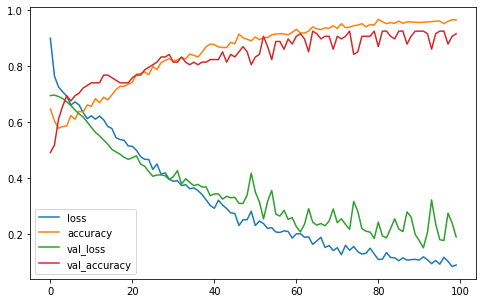

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8916 - accuracy: 0.5288 - val_loss: 0.6828 - val_accuracy: 0.5278
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8010 - accuracy: 0.5864 - val_loss: 0.6821 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7307 - accuracy: 0.5844 - val_loss: 0.6663 - val_accuracy: 0.7130
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7241 - accuracy: 0.5988 - val_loss: 0.6594 - val_accuracy: 0.7315
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6774 - accuracy: 0.6307 - val_loss: 0.6492 - val_accuracy: 0.7593
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6686 - accuracy: 0.6564 - val_loss: 0.6386 - val_accuracy: 0.7870
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6307 - accuracy: 0.6615 - val_loss: 0.6083 - val_accuracy: 

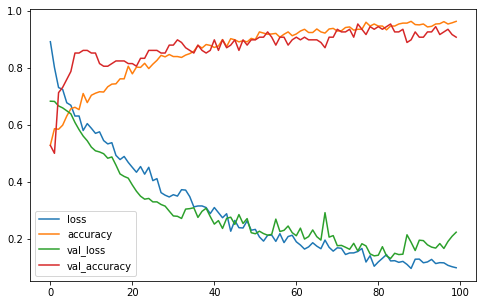

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0367 - accuracy: 0.5031 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8961 - accuracy: 0.5319 - val_loss: 0.6972 - val_accuracy: 0.4444
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8037 - accuracy: 0.5658 - val_loss: 0.6837 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8081 - accuracy: 0.5741 - val_loss: 0.6619 - val_accuracy: 0.6759
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7204 - accuracy: 0.5967 - val_loss: 0.6495 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7081 - accuracy: 0.6019 - val_loss: 0.6364 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7014 - accuracy: 0.6358 - val_loss: 0.6237 - val_accuracy: 

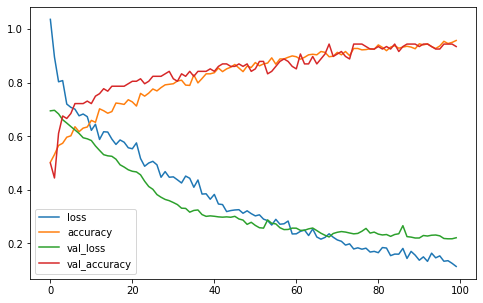

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8805 - accuracy: 0.5761 - val_loss: 0.6959 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8426 - accuracy: 0.5381 - val_loss: 0.6830 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7704 - accuracy: 0.5792 - val_loss: 0.6734 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7906 - accuracy: 0.5628 - val_loss: 0.6607 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7063 - accuracy: 0.6101 - val_loss: 0.6474 - val_accuracy: 0.7407
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6969 - accuracy: 0.6080 - val_loss: 0.6330 - val_accuracy: 0.7778
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6624 - accuracy: 0.6163 - val_loss: 0.6192 - val_accuracy: 

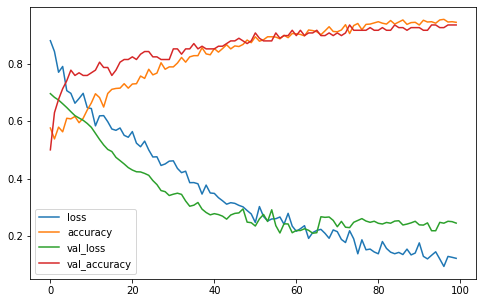

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.1373 - accuracy: 0.5123 - val_loss: 0.7177 - val_accuracy: 0.3889
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9105 - accuracy: 0.5288 - val_loss: 0.7078 - val_accuracy: 0.4259
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8086 - accuracy: 0.5720 - val_loss: 0.6955 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7778 - accuracy: 0.5936 - val_loss: 0.6731 - val_accuracy: 0.6852
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7574 - accuracy: 0.6060 - val_loss: 0.6597 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6837 - accuracy: 0.6193 - val_loss: 0.6473 - val_accuracy: 0.7037
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7088 - accuracy: 0.6091 - val_loss: 0.6395 - val_accuracy: 

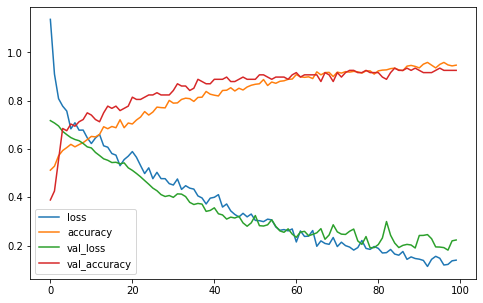

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8640 - accuracy: 0.5288 - val_loss: 0.7088 - val_accuracy: 0.3333
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7980 - accuracy: 0.5165 - val_loss: 0.6994 - val_accuracy: 0.4444
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7139 - accuracy: 0.5813 - val_loss: 0.6878 - val_accuracy: 0.5463
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6986 - accuracy: 0.6204 - val_loss: 0.6662 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6589 - accuracy: 0.6214 - val_loss: 0.6462 - val_accuracy: 0.7593
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6450 - accuracy: 0.6533 - val_loss: 0.6303 - val_accuracy: 0.7778
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6510 - accuracy: 0.6265 - val_loss: 0.6088 - val_accuracy:

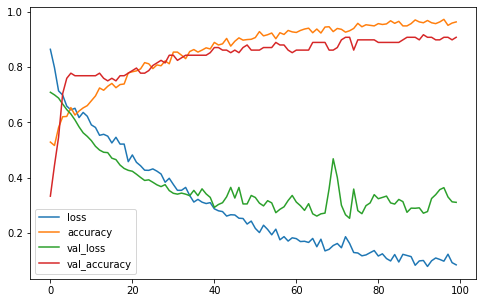

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9684 - accuracy: 0.5370 - val_loss: 0.6864 - val_accuracy: 0.5278
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8215 - accuracy: 0.5586 - val_loss: 0.6824 - val_accuracy: 0.5833
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7570 - accuracy: 0.5689 - val_loss: 0.6714 - val_accuracy: 0.6944
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6991 - accuracy: 0.6379 - val_loss: 0.6656 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7037 - accuracy: 0.6111 - val_loss: 0.6509 - val_accuracy: 0.7500
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6596 - accuracy: 0.6286 - val_loss: 0.6360 - val_accuracy: 0.7593
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6625 - accuracy: 0.6070 - val_loss: 0.6279 - val_accuracy

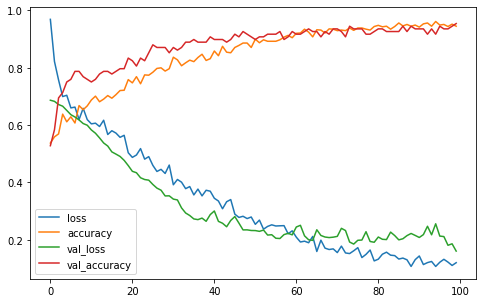

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9482 - accuracy: 0.5916 - val_loss: 0.6945 - val_accuracy: 0.3704
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7853 - accuracy: 0.5730 - val_loss: 0.6939 - val_accuracy: 0.4444
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7296 - accuracy: 0.6039 - val_loss: 0.6814 - val_accuracy: 0.5463
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7066 - accuracy: 0.6276 - val_loss: 0.6609 - val_accuracy: 0.6481
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7280 - accuracy: 0.6255 - val_loss: 0.6404 - val_accuracy: 0.7963
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6701 - accuracy: 0.6132 - val_loss: 0.6223 - val_accuracy: 0.8241
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6742 - accuracy: 0.6101 - val_loss: 0.6091 - val_accuracy

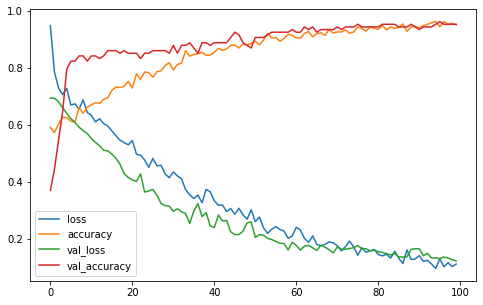

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9706 - accuracy: 0.4722 - val_loss: 0.6847 - val_accuracy: 0.6481
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8556 - accuracy: 0.5545 - val_loss: 0.6791 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7931 - accuracy: 0.5545 - val_loss: 0.6770 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7612 - accuracy: 0.5545 - val_loss: 0.6641 - val_accuracy: 0.6481
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7257 - accuracy: 0.5957 - val_loss: 0.6499 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7377 - accuracy: 0.5823 - val_loss: 0.6402 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6866 - accuracy: 0.5957 - val_loss: 0.6361 - val_accurac

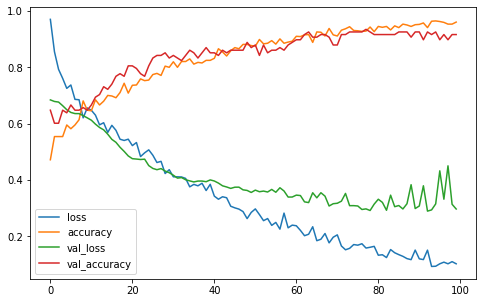

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9609 - accuracy: 0.5237 - val_loss: 0.6921 - val_accuracy: 0.4259
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8378 - accuracy: 0.5226 - val_loss: 0.6694 - val_accuracy: 0.6944
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7687 - accuracy: 0.5545 - val_loss: 0.6676 - val_accuracy: 0.7500
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7494 - accuracy: 0.5700 - val_loss: 0.6656 - val_accuracy: 0.7500
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6697 - accuracy: 0.5916 - val_loss: 0.6553 - val_accuracy: 0.7593
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7174 - accuracy: 0.6060 - val_loss: 0.6409 - val_accuracy: 0.7500
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6729 - accuracy: 0.6379 - val_loss: 0.6316 - val_accura

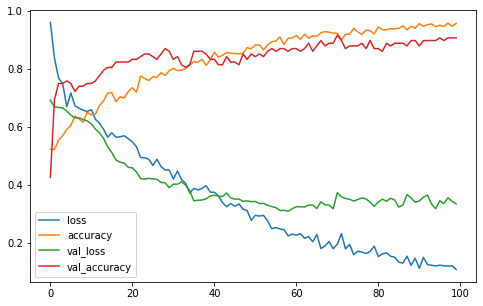

In [22]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9133333504199982
F1_Score  : 0.8958560034279873


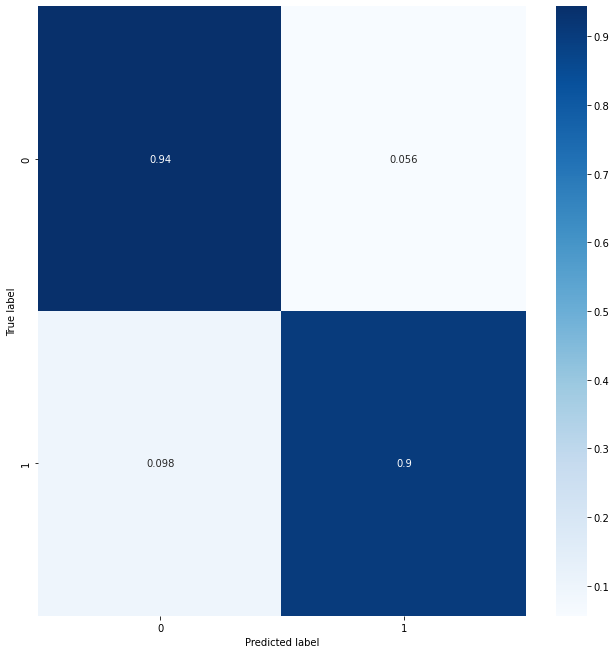

In [23]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 15**

In [24]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(15,16):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.15
(1200, 32, 256, 1)
(1200,) (600,) (600,)
(1200,) (570,) (630,)


3866

# **Valence**

In [25]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9082 - accuracy: 0.5144 - val_loss: 0.6866 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8009 - accuracy: 0.5453 - val_loss: 0.6765 - val_accuracy: 0.6389
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7482 - accuracy: 0.5761 - val_loss: 0.6707 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7226 - accuracy: 0.6019 - val_loss: 0.6619 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7242 - accuracy: 0.5823 - val_loss: 0.6515 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6792 - accuracy: 0.5874 - val_loss: 0.6406 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6512 - accuracy: 0.6132 - val_loss: 0.6329 - val_accuracy: 

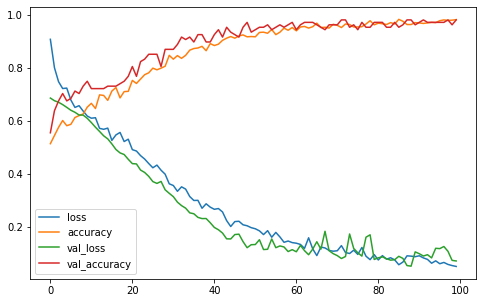

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8814 - accuracy: 0.5473 - val_loss: 0.6848 - val_accuracy: 0.6111
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8151 - accuracy: 0.5453 - val_loss: 0.6830 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7368 - accuracy: 0.5648 - val_loss: 0.6824 - val_accuracy: 0.5648
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7269 - accuracy: 0.5638 - val_loss: 0.6888 - val_accuracy: 0.4907
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6906 - accuracy: 0.5833 - val_loss: 0.6911 - val_accuracy: 0.4815
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6916 - accuracy: 0.6070 - val_loss: 0.6886 - val_accuracy: 0.4815
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6540 - accuracy: 0.6173 - val_loss: 0.6856 - val_accuracy: 

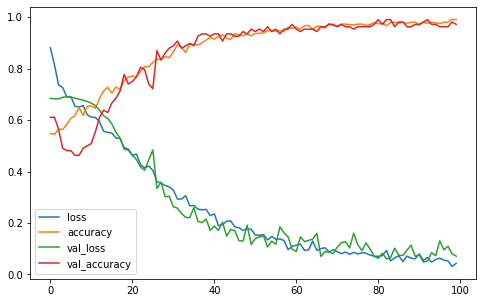

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8741 - accuracy: 0.5093 - val_loss: 0.6877 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8259 - accuracy: 0.5298 - val_loss: 0.6844 - val_accuracy: 0.5741
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7333 - accuracy: 0.5597 - val_loss: 0.6807 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7246 - accuracy: 0.5638 - val_loss: 0.6790 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6789 - accuracy: 0.6121 - val_loss: 0.6780 - val_accuracy: 0.5833
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5967 - val_loss: 0.6747 - val_accuracy: 0.5926
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6957 - accuracy: 0.5679 - val_loss: 0.6704 - val_accuracy: 

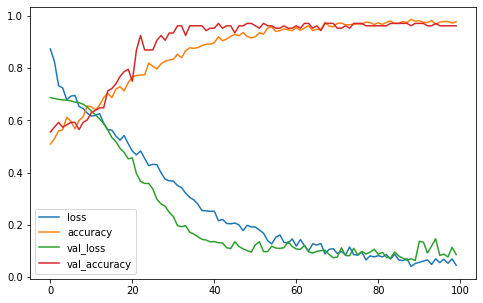

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9233 - accuracy: 0.5185 - val_loss: 0.6879 - val_accuracy: 0.5185
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8121 - accuracy: 0.5329 - val_loss: 0.6757 - val_accuracy: 0.6574
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7880 - accuracy: 0.5556 - val_loss: 0.6689 - val_accuracy: 0.6852
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7574 - accuracy: 0.5463 - val_loss: 0.6663 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6994 - accuracy: 0.6008 - val_loss: 0.6620 - val_accuracy: 0.6852
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7058 - accuracy: 0.5720 - val_loss: 0.6566 - val_accuracy: 0.6944
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6819 - accuracy: 0.5885 - val_loss: 0.6539 - val_accuracy: 

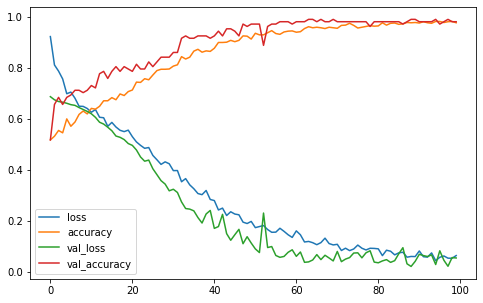

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9890 - accuracy: 0.5226 - val_loss: 0.6819 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8969 - accuracy: 0.5535 - val_loss: 0.6826 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8228 - accuracy: 0.5484 - val_loss: 0.6864 - val_accuracy: 0.5741
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7481 - accuracy: 0.5823 - val_loss: 0.6879 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7425 - accuracy: 0.5720 - val_loss: 0.6843 - val_accuracy: 0.5463
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7234 - accuracy: 0.5936 - val_loss: 0.6859 - val_accuracy: 0.5278
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7155 - accuracy: 0.6019 - val_loss: 0.6801 - val_accuracy: 

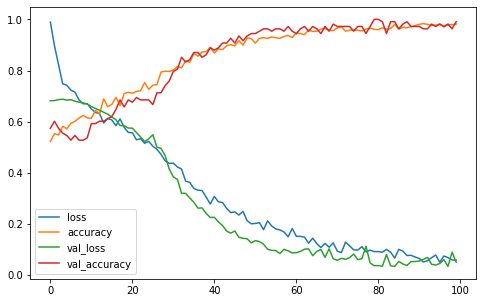

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9645 - accuracy: 0.4969 - val_loss: 0.6818 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7787 - accuracy: 0.5453 - val_loss: 0.6790 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7498 - accuracy: 0.5484 - val_loss: 0.6762 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7008 - accuracy: 0.5977 - val_loss: 0.6735 - val_accuracy: 0.5833
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6858 - accuracy: 0.6008 - val_loss: 0.6723 - val_accuracy: 0.5278
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6640 - accuracy: 0.6101 - val_loss: 0.6680 - val_accuracy: 0.5000
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6593 - accuracy: 0.6060 - val_loss: 0.6645 - val_accuracy:

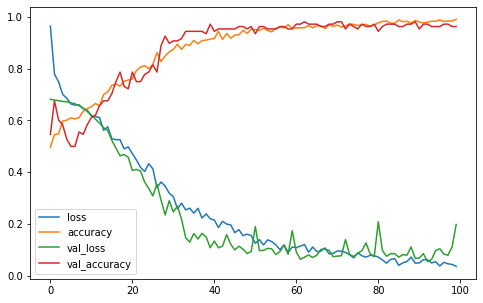

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9021 - accuracy: 0.5165 - val_loss: 0.6908 - val_accuracy: 0.5185
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7811 - accuracy: 0.5257 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7320 - accuracy: 0.5628 - val_loss: 0.6889 - val_accuracy: 0.5000
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7011 - accuracy: 0.5772 - val_loss: 0.6825 - val_accuracy: 0.5463
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6851 - accuracy: 0.5916 - val_loss: 0.6777 - val_accuracy: 0.6111
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6714 - accuracy: 0.6142 - val_loss: 0.6728 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6316 - accuracy: 0.6307 - val_loss: 0.6665 - val_accuracy: 

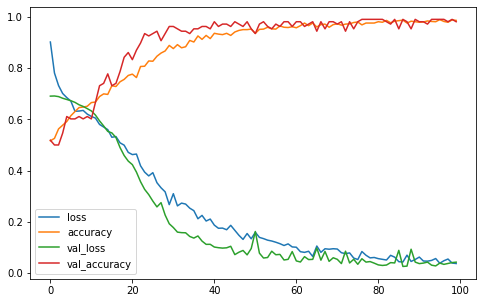

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9640 - accuracy: 0.5329 - val_loss: 0.6973 - val_accuracy: 0.5278
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8379 - accuracy: 0.5545 - val_loss: 0.6883 - val_accuracy: 0.6204
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8532 - accuracy: 0.5494 - val_loss: 0.6799 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7454 - accuracy: 0.6029 - val_loss: 0.6744 - val_accuracy: 0.6019
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7713 - accuracy: 0.5669 - val_loss: 0.6672 - val_accuracy: 0.6019
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7006 - accuracy: 0.6111 - val_loss: 0.6602 - val_accuracy: 0.5926
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7406 - accuracy: 0.5936 - val_loss: 0.6519 - val_accurac

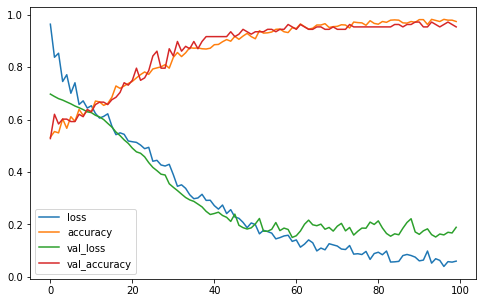

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9374 - accuracy: 0.5216 - val_loss: 0.6875 - val_accuracy: 0.6296
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8747 - accuracy: 0.5442 - val_loss: 0.6787 - val_accuracy: 0.6574
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7751 - accuracy: 0.5648 - val_loss: 0.6758 - val_accuracy: 0.6481
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7744 - accuracy: 0.5350 - val_loss: 0.6749 - val_accuracy: 0.6389
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7264 - accuracy: 0.5854 - val_loss: 0.6720 - val_accuracy: 0.6111
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7024 - accuracy: 0.6070 - val_loss: 0.6701 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6892 - accuracy: 0.5895 - val_loss: 0.6663 - val_accurac

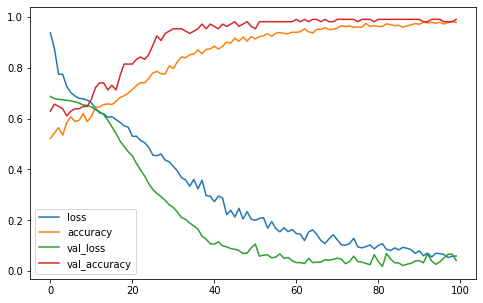

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9854 - accuracy: 0.5113 - val_loss: 0.6851 - val_accuracy: 0.6111
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8759 - accuracy: 0.5288 - val_loss: 0.6698 - val_accuracy: 0.7037
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7965 - accuracy: 0.5597 - val_loss: 0.6644 - val_accuracy: 0.7315
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7713 - accuracy: 0.5586 - val_loss: 0.6609 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7362 - accuracy: 0.5782 - val_loss: 0.6577 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7150 - accuracy: 0.5998 - val_loss: 0.6497 - val_accuracy: 0.7222
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6953 - accuracy: 0.6029 - val_loss: 0.6458 - val_accura

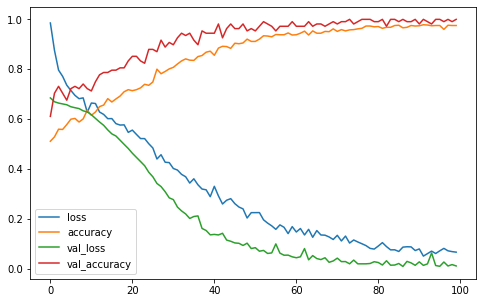

In [26]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9616666674613953
F1_Score  : 0.961644302327544


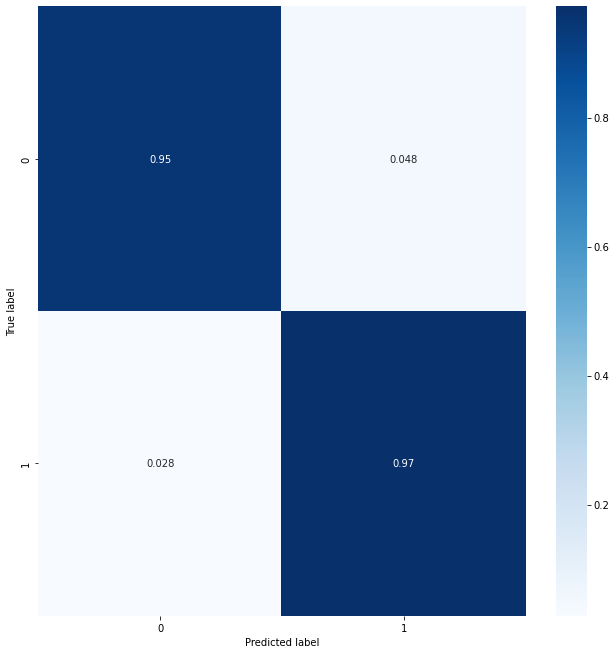

In [27]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [28]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9559 - accuracy: 0.5319 - val_loss: 0.6668 - val_accuracy: 0.6944
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8030 - accuracy: 0.5751 - val_loss: 0.6670 - val_accuracy: 0.6852
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7501 - accuracy: 0.5998 - val_loss: 0.6660 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7106 - accuracy: 0.6307 - val_loss: 0.6576 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7191 - accuracy: 0.6008 - val_loss: 0.6488 - val_accuracy: 0.6019
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6774 - accuracy: 0.6317 - val_loss: 0.6486 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6637 - accuracy: 0.6564 - val_loss: 0.6396 - val_accuracy: 

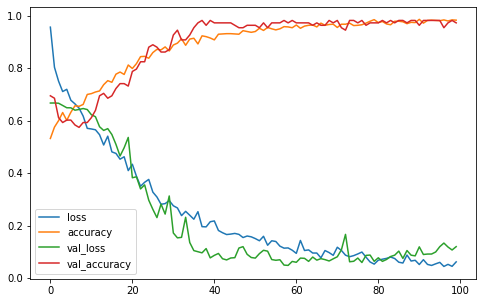

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9243 - accuracy: 0.5381 - val_loss: 0.6668 - val_accuracy: 0.6667
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8084 - accuracy: 0.5864 - val_loss: 0.6706 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7499 - accuracy: 0.5802 - val_loss: 0.6709 - val_accuracy: 0.5370
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6978 - accuracy: 0.6296 - val_loss: 0.6725 - val_accuracy: 0.5278
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6786 - accuracy: 0.6368 - val_loss: 0.6706 - val_accuracy: 0.5370
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6489 - accuracy: 0.6451 - val_loss: 0.6739 - val_accuracy: 0.5278
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6422 - accuracy: 0.6646 - val_loss: 0.6894 - val_accuracy: 

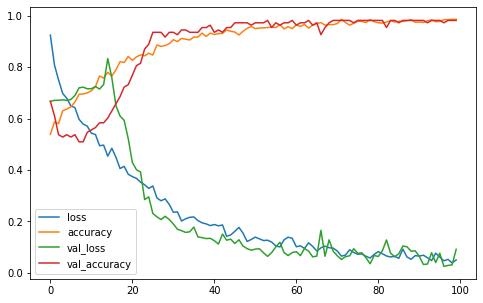

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 1.0253 - accuracy: 0.5340 - val_loss: 0.6854 - val_accuracy: 0.6296
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8385 - accuracy: 0.5648 - val_loss: 0.6755 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7656 - accuracy: 0.5844 - val_loss: 0.6651 - val_accuracy: 0.6389
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7588 - accuracy: 0.5700 - val_loss: 0.6601 - val_accuracy: 0.6389
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6910 - accuracy: 0.5895 - val_loss: 0.6500 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6859 - accuracy: 0.6080 - val_loss: 0.6388 - val_accuracy: 0.6389
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6209 - accuracy: 0.6553 - val_loss: 0.6274 - val_accuracy: 

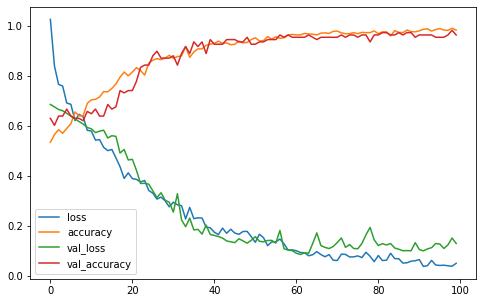

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8847 - accuracy: 0.5237 - val_loss: 0.6855 - val_accuracy: 0.6389
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7657 - accuracy: 0.5494 - val_loss: 0.6850 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7282 - accuracy: 0.5514 - val_loss: 0.6821 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6913 - accuracy: 0.5823 - val_loss: 0.6780 - val_accuracy: 0.5463
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6548 - accuracy: 0.6409 - val_loss: 0.6747 - val_accuracy: 0.5278
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6584 - accuracy: 0.6173 - val_loss: 0.6768 - val_accuracy: 0.5370
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6040 - accuracy: 0.6574 - val_loss: 0.6844 - val_accuracy: 

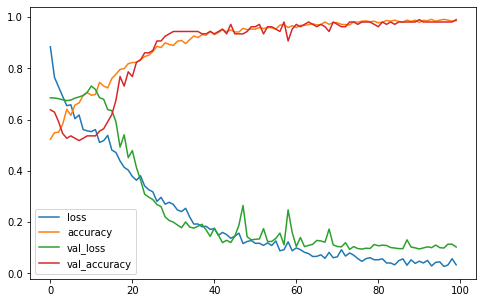

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0430 - accuracy: 0.4938 - val_loss: 0.6789 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8215 - accuracy: 0.5792 - val_loss: 0.6634 - val_accuracy: 0.6944
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7860 - accuracy: 0.6029 - val_loss: 0.6542 - val_accuracy: 0.6852
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7348 - accuracy: 0.6142 - val_loss: 0.6426 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7174 - accuracy: 0.6255 - val_loss: 0.6346 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6588 - accuracy: 0.6564 - val_loss: 0.6202 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6478 - accuracy: 0.6759 - val_loss: 0.6114 - val_accuracy: 

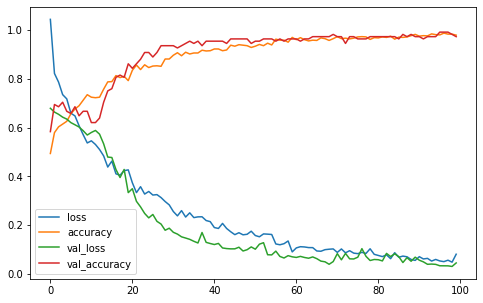

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9648 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.5093
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8230 - accuracy: 0.5257 - val_loss: 0.6830 - val_accuracy: 0.5833
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7446 - accuracy: 0.5936 - val_loss: 0.6720 - val_accuracy: 0.7222
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7396 - accuracy: 0.5669 - val_loss: 0.6619 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6739 - accuracy: 0.5998 - val_loss: 0.6494 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6708 - accuracy: 0.6276 - val_loss: 0.6336 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6449 - accuracy: 0.6265 - val_loss: 0.6192 - val_accuracy:

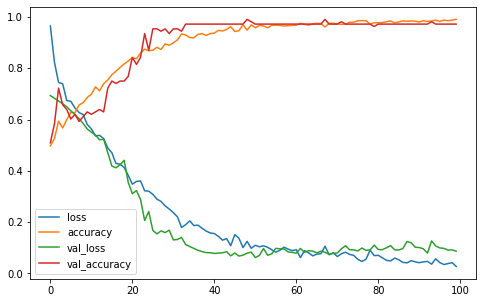

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0440 - accuracy: 0.5041 - val_loss: 0.6812 - val_accuracy: 0.6296
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9149 - accuracy: 0.5103 - val_loss: 0.6824 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7721 - accuracy: 0.5792 - val_loss: 0.6840 - val_accuracy: 0.4815
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7491 - accuracy: 0.5844 - val_loss: 0.6824 - val_accuracy: 0.4722
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7269 - accuracy: 0.5679 - val_loss: 0.6748 - val_accuracy: 0.4722
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7151 - accuracy: 0.5782 - val_loss: 0.6694 - val_accuracy: 0.4722
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6641 - accuracy: 0.6080 - val_loss: 0.6593 - val_accuracy:

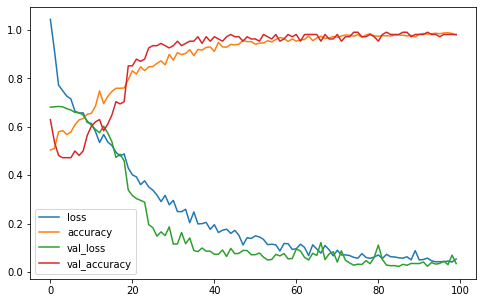

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 1.0031 - accuracy: 0.5401 - val_loss: 0.6450 - val_accuracy: 0.7222
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.9451 - accuracy: 0.5401 - val_loss: 0.6476 - val_accuracy: 0.7037
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8598 - accuracy: 0.5628 - val_loss: 0.6496 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7504 - accuracy: 0.6080 - val_loss: 0.6405 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6935 - accuracy: 0.6430 - val_loss: 0.6266 - val_accuracy: 0.7130
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7440 - accuracy: 0.6101 - val_loss: 0.6110 - val_accuracy: 0.7130
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6814 - accuracy: 0.6399 - val_loss: 0.5994 - val_accurac

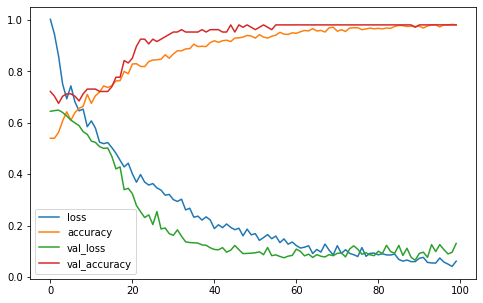

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8716 - accuracy: 0.5288 - val_loss: 0.6851 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8052 - accuracy: 0.5586 - val_loss: 0.6731 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7059 - accuracy: 0.5967 - val_loss: 0.6587 - val_accuracy: 0.6389
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7132 - accuracy: 0.5936 - val_loss: 0.6472 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6442 - accuracy: 0.6409 - val_loss: 0.6352 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6423 - accuracy: 0.6276 - val_loss: 0.6251 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6237 - accuracy: 0.6584 - val_loss: 0.6170 - val_accurac

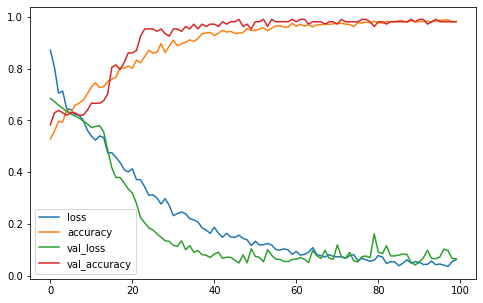

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9690 - accuracy: 0.5381 - val_loss: 0.6762 - val_accuracy: 0.6574
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8365 - accuracy: 0.5720 - val_loss: 0.6540 - val_accuracy: 0.6852
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7612 - accuracy: 0.5854 - val_loss: 0.6393 - val_accuracy: 0.7500
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6836 - accuracy: 0.6091 - val_loss: 0.6200 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6661 - accuracy: 0.6440 - val_loss: 0.6110 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6303 - accuracy: 0.6677 - val_loss: 0.6049 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6212 - accuracy: 0.6543 - val_loss: 0.5878 - val_accurac

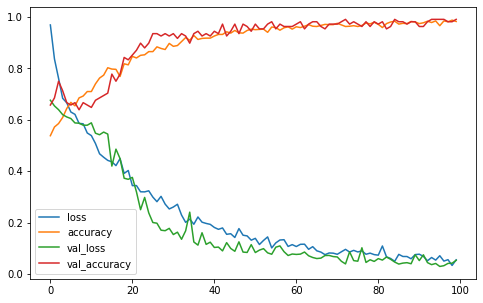

In [29]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9800000011920929
F1_Score  : 0.979690500543378


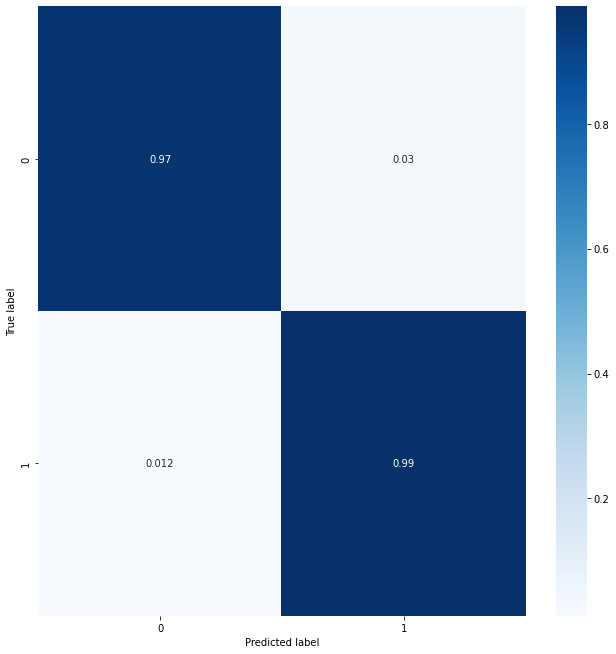

In [30]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 16**

In [31]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(16,17):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.16
(1200, 32, 256, 1)
(1200,) (750,) (450,)
(1200,) (600,) (600,)


3576

# **Valence**

In [32]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9379 - accuracy: 0.4671 - val_loss: 0.6833 - val_accuracy: 0.6389
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7900 - accuracy: 0.5772 - val_loss: 0.6691 - val_accuracy: 0.6389
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7419 - accuracy: 0.5761 - val_loss: 0.6673 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6973 - accuracy: 0.5813 - val_loss: 0.6633 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6837 - accuracy: 0.5936 - val_loss: 0.6568 - val_accuracy: 0.6296
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6655 - accuracy: 0.6204 - val_loss: 0.6355 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6544 - accuracy: 0.6440 - val_loss: 0.6173 - val_accuracy: 

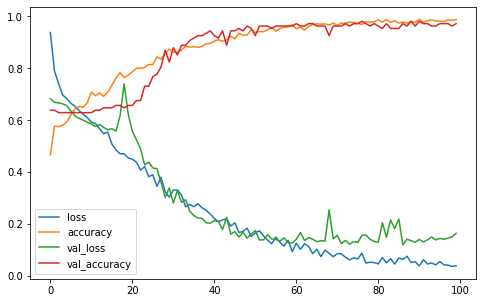

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9463 - accuracy: 0.5144 - val_loss: 0.6793 - val_accuracy: 0.6667
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8263 - accuracy: 0.5710 - val_loss: 0.6498 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8012 - accuracy: 0.5689 - val_loss: 0.6340 - val_accuracy: 0.6667
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7475 - accuracy: 0.5854 - val_loss: 0.6210 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7150 - accuracy: 0.6317 - val_loss: 0.6148 - val_accuracy: 0.6574
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6699 - accuracy: 0.6379 - val_loss: 0.6098 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6813 - accuracy: 0.6502 - val_loss: 0.6060 - val_accuracy: 

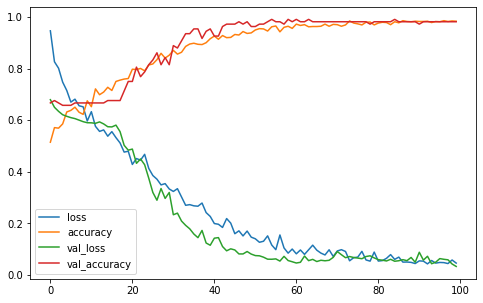

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9554 - accuracy: 0.4578 - val_loss: 0.6937 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7780 - accuracy: 0.5617 - val_loss: 0.6803 - val_accuracy: 0.5741
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7386 - accuracy: 0.5700 - val_loss: 0.6718 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7235 - accuracy: 0.5761 - val_loss: 0.6664 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6542 - accuracy: 0.6224 - val_loss: 0.6615 - val_accuracy: 0.5833
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6743 - accuracy: 0.6245 - val_loss: 0.6617 - val_accuracy: 0.5833
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6433 - accuracy: 0.6564 - val_loss: 0.6648 - val_accuracy: 

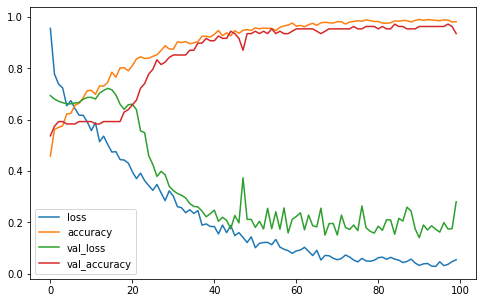

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0816 - accuracy: 0.4877 - val_loss: 0.6797 - val_accuracy: 0.6944
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8571 - accuracy: 0.5679 - val_loss: 0.6634 - val_accuracy: 0.6852
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7919 - accuracy: 0.5957 - val_loss: 0.6446 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7554 - accuracy: 0.5905 - val_loss: 0.6229 - val_accuracy: 0.6852
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7206 - accuracy: 0.5988 - val_loss: 0.6121 - val_accuracy: 0.6852
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6814 - accuracy: 0.6245 - val_loss: 0.5919 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6908 - accuracy: 0.6461 - val_loss: 0.5775 - val_accuracy: 

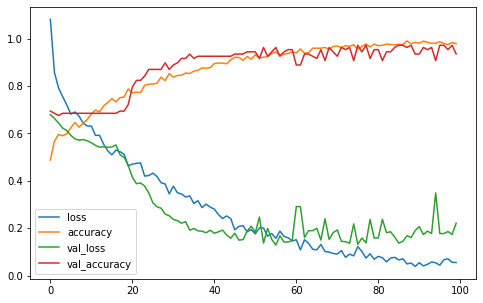

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8458 - accuracy: 0.5185 - val_loss: 0.6851 - val_accuracy: 0.6944
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7756 - accuracy: 0.5648 - val_loss: 0.6706 - val_accuracy: 0.6574
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7077 - accuracy: 0.6111 - val_loss: 0.6548 - val_accuracy: 0.6204
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6655 - accuracy: 0.6245 - val_loss: 0.6405 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6466 - accuracy: 0.6337 - val_loss: 0.6277 - val_accuracy: 0.6296
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6518 - accuracy: 0.6481 - val_loss: 0.6170 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5896 - accuracy: 0.6811 - val_loss: 0.6129 - val_accuracy: 

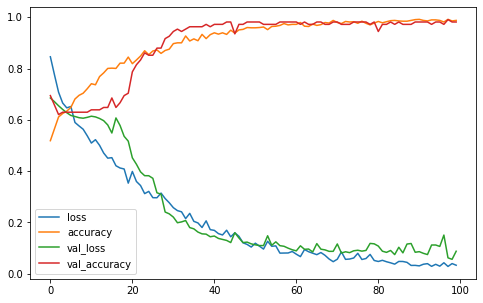

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9368 - accuracy: 0.5370 - val_loss: 0.6753 - val_accuracy: 0.7130
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8336 - accuracy: 0.5597 - val_loss: 0.6611 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7591 - accuracy: 0.5813 - val_loss: 0.6564 - val_accuracy: 0.5648
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7030 - accuracy: 0.6163 - val_loss: 0.6553 - val_accuracy: 0.5648
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6814 - accuracy: 0.6245 - val_loss: 0.6578 - val_accuracy: 0.5648
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6657 - accuracy: 0.6440 - val_loss: 0.6687 - val_accuracy: 0.5648
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6524 - accuracy: 0.6420 - val_loss: 0.6740 - val_accuracy: 

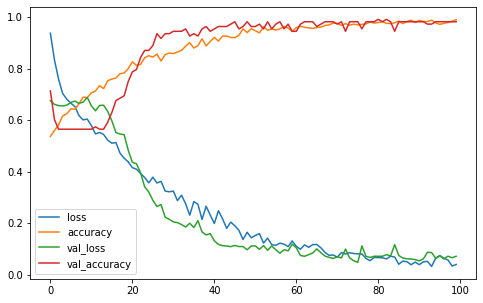

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9208 - accuracy: 0.5576 - val_loss: 0.6936 - val_accuracy: 0.4444
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8495 - accuracy: 0.5710 - val_loss: 0.6817 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7743 - accuracy: 0.5669 - val_loss: 0.6573 - val_accuracy: 0.6944
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7200 - accuracy: 0.6121 - val_loss: 0.6393 - val_accuracy: 0.6852
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6829 - accuracy: 0.6379 - val_loss: 0.6250 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6981 - accuracy: 0.6420 - val_loss: 0.6147 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6865 - accuracy: 0.6461 - val_loss: 0.6085 - val_accuracy:

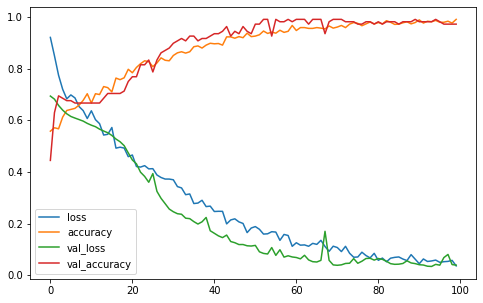

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9192 - accuracy: 0.5298 - val_loss: 0.6794 - val_accuracy: 0.6111
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7982 - accuracy: 0.5864 - val_loss: 0.6641 - val_accuracy: 0.7037
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7494 - accuracy: 0.6101 - val_loss: 0.6519 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7219 - accuracy: 0.6029 - val_loss: 0.6415 - val_accuracy: 0.6111
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6723 - accuracy: 0.6533 - val_loss: 0.6285 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6499 - accuracy: 0.6420 - val_loss: 0.6224 - val_accuracy: 0.6204
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6290 - accuracy: 0.6687 - val_loss: 0.6193 - val_accuracy:

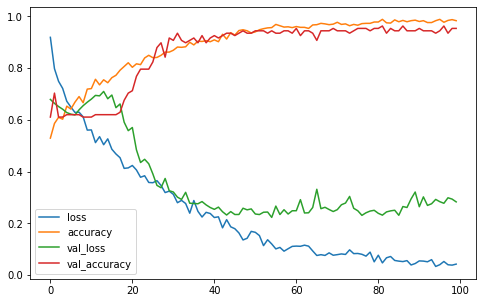

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8836 - accuracy: 0.4866 - val_loss: 0.6839 - val_accuracy: 0.5926
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7758 - accuracy: 0.5730 - val_loss: 0.6602 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7163 - accuracy: 0.6060 - val_loss: 0.6410 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6771 - accuracy: 0.6368 - val_loss: 0.6281 - val_accuracy: 0.6759
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7042 - accuracy: 0.6317 - val_loss: 0.6125 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6407 - accuracy: 0.6626 - val_loss: 0.6039 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6264 - accuracy: 0.6728 - val_loss: 0.5983 - val_accuracy:

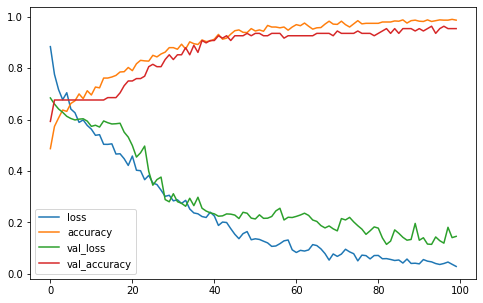

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8304 - accuracy: 0.5494 - val_loss: 0.6819 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7502 - accuracy: 0.5977 - val_loss: 0.6457 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7235 - accuracy: 0.6348 - val_loss: 0.6325 - val_accuracy: 0.6574
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7028 - accuracy: 0.6276 - val_loss: 0.6312 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6551 - accuracy: 0.6440 - val_loss: 0.6338 - val_accuracy: 0.6296
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6657 - accuracy: 0.6430 - val_loss: 0.6324 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6031 - accuracy: 0.6883 - val_loss: 0.6371 - val_accuracy:

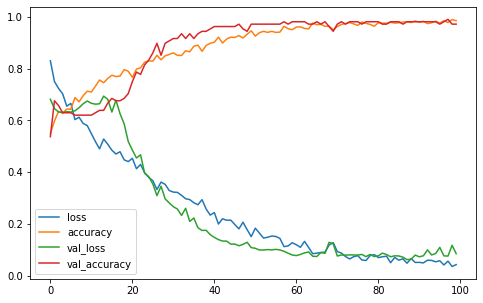

In [33]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9691666543483735
F1_Score  : 0.9675374905655666


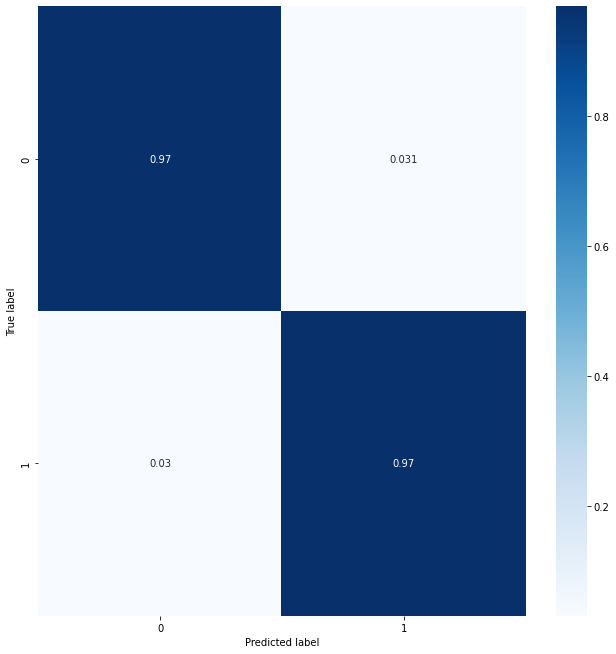

In [34]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [35]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 1.0555 - accuracy: 0.5154 - val_loss: 0.6800 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8727 - accuracy: 0.5700 - val_loss: 0.6616 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7867 - accuracy: 0.5689 - val_loss: 0.6707 - val_accuracy: 0.5648
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7158 - accuracy: 0.6101 - val_loss: 0.7033 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6777 - accuracy: 0.6214 - val_loss: 0.7688 - val_accuracy: 0.5556
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6191 - accuracy: 0.6584 - val_loss: 0.8826 - val_accuracy: 0.5648
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6377 - accuracy: 0.6481 - val_loss: 0.9746 - val_accuracy: 

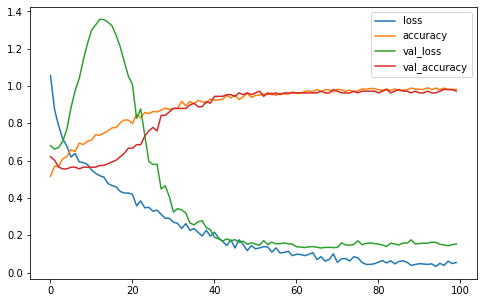

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9698 - accuracy: 0.5113 - val_loss: 0.6826 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7732 - accuracy: 0.5833 - val_loss: 0.6780 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7266 - accuracy: 0.5792 - val_loss: 0.6831 - val_accuracy: 0.5370
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6788 - accuracy: 0.6101 - val_loss: 0.7015 - val_accuracy: 0.4259
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6419 - accuracy: 0.6564 - val_loss: 0.7269 - val_accuracy: 0.4352
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6441 - accuracy: 0.6440 - val_loss: 0.7700 - val_accuracy: 0.4352
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6077 - accuracy: 0.6790 - val_loss: 0.8489 - val_accuracy:

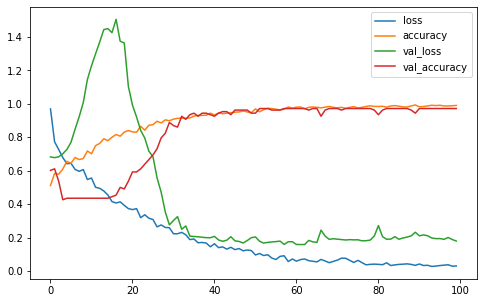

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9514 - accuracy: 0.5576 - val_loss: 0.6859 - val_accuracy: 0.5278
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7941 - accuracy: 0.5710 - val_loss: 0.6764 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7455 - accuracy: 0.6060 - val_loss: 0.6771 - val_accuracy: 0.5741
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6588 - accuracy: 0.6399 - val_loss: 0.6870 - val_accuracy: 0.5370
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6866 - accuracy: 0.6502 - val_loss: 0.7148 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6230 - accuracy: 0.6481 - val_loss: 0.7530 - val_accuracy: 0.5185
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5547 - accuracy: 0.7078 - val_loss: 0.8070 - val_accuracy: 

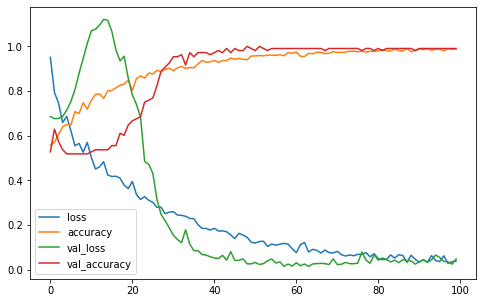

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9174 - accuracy: 0.5422 - val_loss: 0.6850 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8130 - accuracy: 0.5638 - val_loss: 0.6795 - val_accuracy: 0.5556
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7333 - accuracy: 0.5977 - val_loss: 0.6815 - val_accuracy: 0.5278
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6707 - accuracy: 0.6183 - val_loss: 0.6861 - val_accuracy: 0.5278
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6427 - accuracy: 0.6502 - val_loss: 0.7112 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6284 - accuracy: 0.6451 - val_loss: 0.7392 - val_accuracy: 0.5278
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5736 - accuracy: 0.6955 - val_loss: 0.7709 - val_accuracy: 

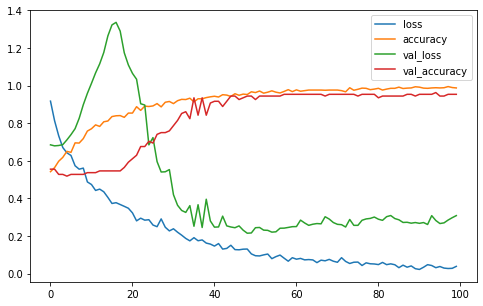

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9348 - accuracy: 0.5350 - val_loss: 0.6833 - val_accuracy: 0.6759
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8212 - accuracy: 0.5586 - val_loss: 0.6776 - val_accuracy: 0.4907
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7192 - accuracy: 0.5957 - val_loss: 0.6798 - val_accuracy: 0.4722
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7264 - accuracy: 0.5905 - val_loss: 0.6848 - val_accuracy: 0.4630
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6715 - accuracy: 0.6502 - val_loss: 0.7129 - val_accuracy: 0.4630
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6269 - accuracy: 0.6389 - val_loss: 0.7655 - val_accuracy: 0.4722
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6312 - accuracy: 0.6615 - val_loss: 0.8301 - val_accuracy: 

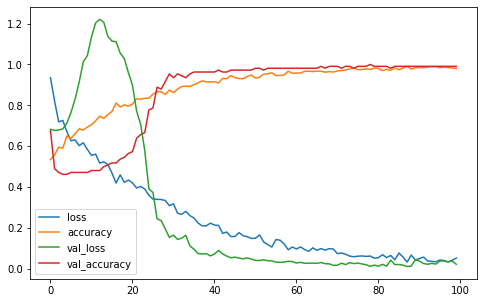

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0849 - accuracy: 0.5350 - val_loss: 0.6755 - val_accuracy: 0.6852
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8602 - accuracy: 0.5669 - val_loss: 0.6795 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7953 - accuracy: 0.5957 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7243 - accuracy: 0.6204 - val_loss: 0.7239 - val_accuracy: 0.4815
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6853 - accuracy: 0.6420 - val_loss: 0.7605 - val_accuracy: 0.4815
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6183 - accuracy: 0.6728 - val_loss: 0.8278 - val_accuracy: 0.4722
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6073 - accuracy: 0.6800 - val_loss: 0.9351 - val_accuracy:

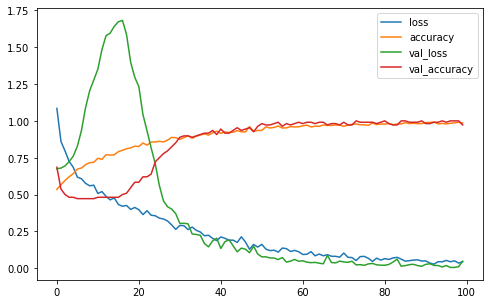

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.8740 - accuracy: 0.5195 - val_loss: 0.6840 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8127 - accuracy: 0.5463 - val_loss: 0.6718 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7045 - accuracy: 0.6029 - val_loss: 0.6597 - val_accuracy: 0.6204
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6875 - accuracy: 0.6142 - val_loss: 0.6559 - val_accuracy: 0.5833
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6428 - accuracy: 0.6667 - val_loss: 0.6692 - val_accuracy: 0.5741
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6145 - accuracy: 0.6708 - val_loss: 0.7008 - val_accuracy: 0.5648
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6295 - accuracy: 0.6770 - val_loss: 0.7275 - val_accuracy:

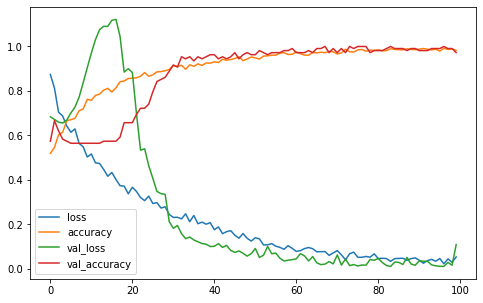

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9541 - accuracy: 0.5360 - val_loss: 0.6748 - val_accuracy: 0.7037
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8101 - accuracy: 0.5710 - val_loss: 0.6671 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7358 - accuracy: 0.5988 - val_loss: 0.6689 - val_accuracy: 0.5370
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6862 - accuracy: 0.6307 - val_loss: 0.7019 - val_accuracy: 0.5093
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6734 - accuracy: 0.6430 - val_loss: 0.7440 - val_accuracy: 0.5000
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6515 - accuracy: 0.6739 - val_loss: 0.7766 - val_accuracy: 0.5093
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5841 - accuracy: 0.7068 - val_loss: 0.8465 - val_accuracy:

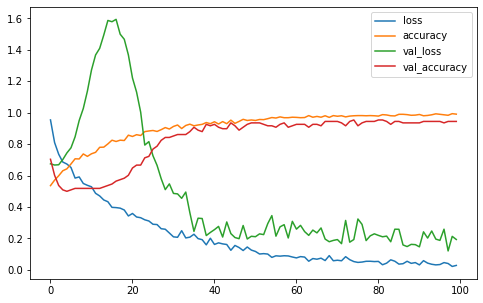

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8768 - accuracy: 0.5103 - val_loss: 0.6851 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7452 - accuracy: 0.5772 - val_loss: 0.6741 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7123 - accuracy: 0.5977 - val_loss: 0.6727 - val_accuracy: 0.5463
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6359 - accuracy: 0.6358 - val_loss: 0.6871 - val_accuracy: 0.5463
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6149 - accuracy: 0.6553 - val_loss: 0.7273 - val_accuracy: 0.5556
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6201 - accuracy: 0.6595 - val_loss: 0.7891 - val_accuracy: 0.5556
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5524 - accuracy: 0.7171 - val_loss: 0.8988 - val_accuracy:

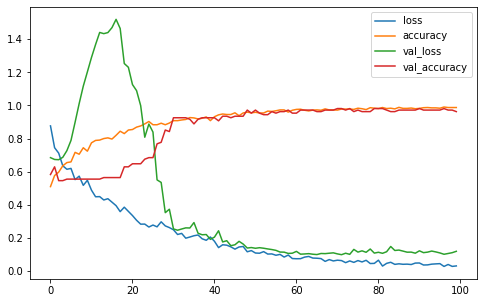

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9388 - accuracy: 0.5525 - val_loss: 0.6798 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8212 - accuracy: 0.5833 - val_loss: 0.6806 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7026 - accuracy: 0.5977 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7078 - accuracy: 0.6101 - val_loss: 0.7245 - val_accuracy: 0.5000
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6568 - accuracy: 0.6430 - val_loss: 0.7654 - val_accuracy: 0.5000
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6285 - accuracy: 0.6481 - val_loss: 0.8158 - val_accuracy: 0.5000
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6126 - accuracy: 0.6790 - val_loss: 0.9115 - val_accurac

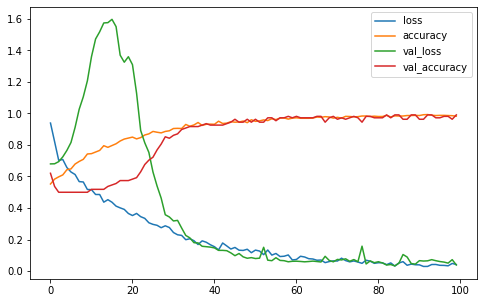

In [36]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9758333384990692
F1_Score  : 0.9758004215802488


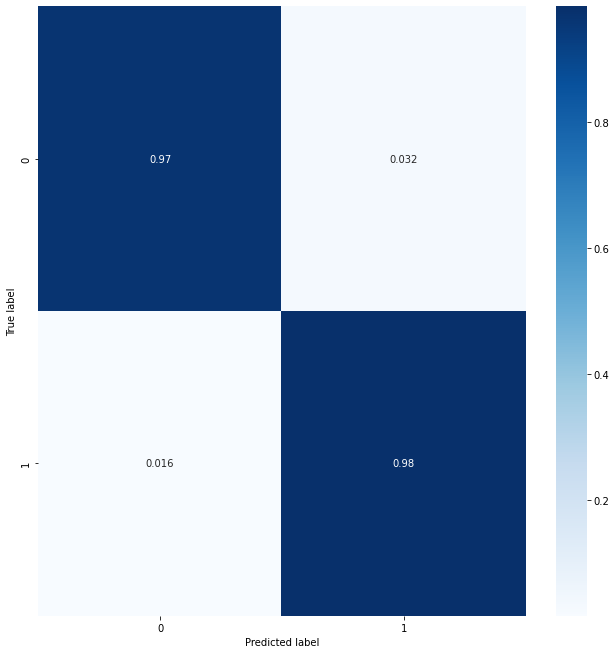

In [37]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 17**

In [38]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(17,18):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.17
(1200, 32, 256, 1)
(1200,) (540,) (660,)
(1200,) (450,) (750,)


3576

# **Valence**

In [39]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 20ms/step - loss: 1.0281 - accuracy: 0.4897 - val_loss: 0.7008 - val_accuracy: 0.4815
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9308 - accuracy: 0.5123 - val_loss: 0.6736 - val_accuracy: 0.5833
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8948 - accuracy: 0.4979 - val_loss: 0.6760 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8464 - accuracy: 0.5257 - val_loss: 0.6774 - val_accuracy: 0.5648
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8110 - accuracy: 0.5267 - val_loss: 0.6804 - val_accuracy: 0.5926
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7687 - accuracy: 0.5401 - val_loss: 0.6770 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7908 - accuracy: 0.5216 - val_loss: 0.6759 - val_accuracy: 

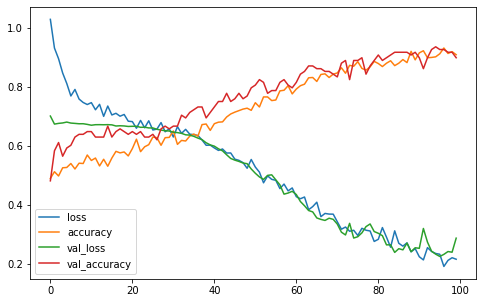

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 1.0416 - accuracy: 0.4856 - val_loss: 0.6945 - val_accuracy: 0.4630
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8713 - accuracy: 0.5062 - val_loss: 0.6936 - val_accuracy: 0.4444
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8113 - accuracy: 0.5154 - val_loss: 0.6965 - val_accuracy: 0.4537
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8266 - accuracy: 0.5021 - val_loss: 0.6975 - val_accuracy: 0.4259
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7731 - accuracy: 0.5267 - val_loss: 0.6990 - val_accuracy: 0.4444
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7652 - accuracy: 0.5247 - val_loss: 0.6995 - val_accuracy: 0.4352
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7718 - accuracy: 0.5278 - val_loss: 0.6983 - val_accuracy: 

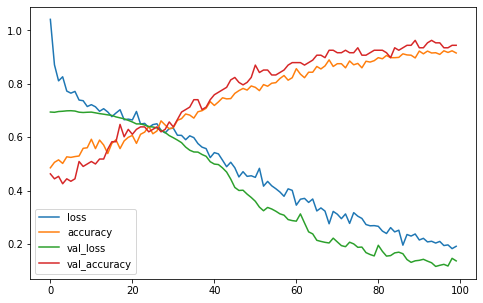

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9409 - accuracy: 0.4959 - val_loss: 0.7089 - val_accuracy: 0.4259
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8488 - accuracy: 0.5278 - val_loss: 0.7015 - val_accuracy: 0.4630
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8187 - accuracy: 0.5072 - val_loss: 0.6988 - val_accuracy: 0.4259
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8270 - accuracy: 0.5144 - val_loss: 0.6983 - val_accuracy: 0.4907
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7756 - accuracy: 0.5267 - val_loss: 0.6962 - val_accuracy: 0.4907
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7474 - accuracy: 0.5360 - val_loss: 0.7019 - val_accuracy: 0.4722
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7413 - accuracy: 0.5412 - val_loss: 0.7061 - val_accuracy:

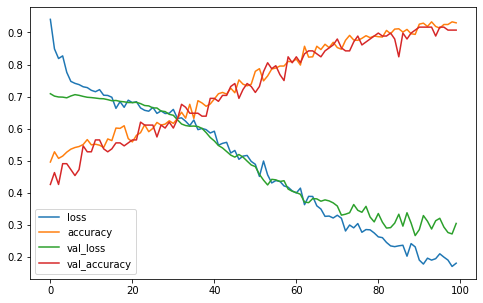

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 1.0285 - accuracy: 0.4918 - val_loss: 0.6907 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8634 - accuracy: 0.5093 - val_loss: 0.6803 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8386 - accuracy: 0.5000 - val_loss: 0.6785 - val_accuracy: 0.6574
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7869 - accuracy: 0.5401 - val_loss: 0.6772 - val_accuracy: 0.6481
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7478 - accuracy: 0.5504 - val_loss: 0.6774 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7382 - accuracy: 0.5185 - val_loss: 0.6772 - val_accuracy: 0.6204
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7407 - accuracy: 0.5329 - val_loss: 0.6760 - val_accuracy: 

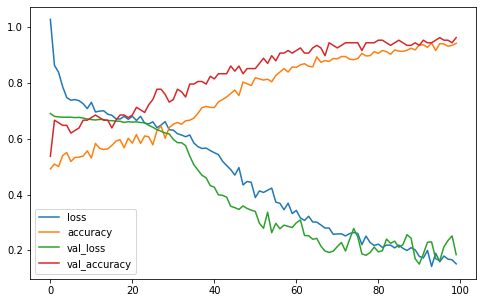

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9882 - accuracy: 0.5103 - val_loss: 0.6859 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9225 - accuracy: 0.5051 - val_loss: 0.6925 - val_accuracy: 0.5093
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8876 - accuracy: 0.5298 - val_loss: 0.6887 - val_accuracy: 0.5463
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8295 - accuracy: 0.5370 - val_loss: 0.6841 - val_accuracy: 0.5463
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8096 - accuracy: 0.5545 - val_loss: 0.6851 - val_accuracy: 0.5741
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7960 - accuracy: 0.5576 - val_loss: 0.6849 - val_accuracy: 0.5648
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7747 - accuracy: 0.5412 - val_loss: 0.6810 - val_accuracy: 

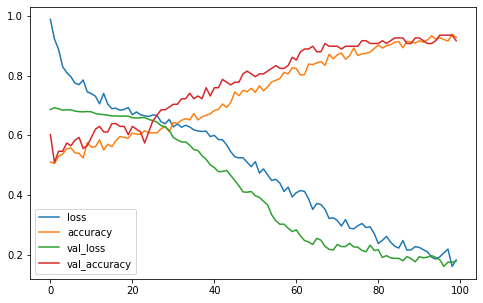

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0056 - accuracy: 0.4949 - val_loss: 0.7118 - val_accuracy: 0.4907
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8766 - accuracy: 0.5134 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8287 - accuracy: 0.5206 - val_loss: 0.6875 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8149 - accuracy: 0.5144 - val_loss: 0.6859 - val_accuracy: 0.5093
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7687 - accuracy: 0.5237 - val_loss: 0.6853 - val_accuracy: 0.5370
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7545 - accuracy: 0.5350 - val_loss: 0.6880 - val_accuracy: 0.5556
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7227 - accuracy: 0.5586 - val_loss: 0.6857 - val_accuracy: 

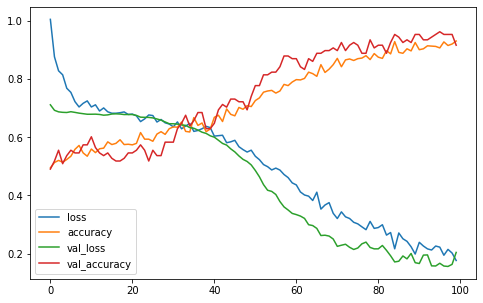

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9811 - accuracy: 0.4979 - val_loss: 0.6895 - val_accuracy: 0.4815
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8909 - accuracy: 0.4959 - val_loss: 0.6878 - val_accuracy: 0.5278
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8041 - accuracy: 0.5473 - val_loss: 0.6849 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8286 - accuracy: 0.5062 - val_loss: 0.6835 - val_accuracy: 0.6019
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7918 - accuracy: 0.5360 - val_loss: 0.6824 - val_accuracy: 0.6111
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8051 - accuracy: 0.5082 - val_loss: 0.6823 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7308 - accuracy: 0.5401 - val_loss: 0.6811 - val_accuracy:

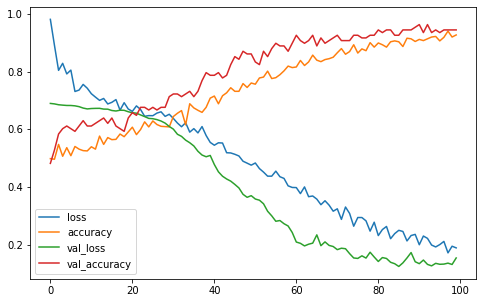

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 1.0107 - accuracy: 0.5113 - val_loss: 0.6864 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.9377 - accuracy: 0.5010 - val_loss: 0.6909 - val_accuracy: 0.5463
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8918 - accuracy: 0.4928 - val_loss: 0.6851 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8353 - accuracy: 0.5093 - val_loss: 0.6817 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8053 - accuracy: 0.5319 - val_loss: 0.6805 - val_accuracy: 0.5648
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7926 - accuracy: 0.5237 - val_loss: 0.6773 - val_accuracy: 0.5556
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8038 - accuracy: 0.5247 - val_loss: 0.6723 - val_accuracy:

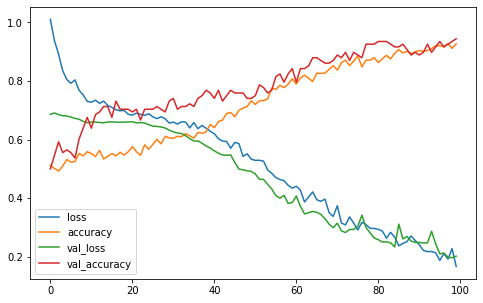

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 24ms/step - loss: 0.9630 - accuracy: 0.4979 - val_loss: 0.6856 - val_accuracy: 0.5093
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.9470 - accuracy: 0.4887 - val_loss: 0.6794 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8559 - accuracy: 0.5401 - val_loss: 0.6758 - val_accuracy: 0.5741
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8399 - accuracy: 0.5391 - val_loss: 0.6694 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8136 - accuracy: 0.5072 - val_loss: 0.6652 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7677 - accuracy: 0.5473 - val_loss: 0.6641 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7605 - accuracy: 0.5350 - val_loss: 0.6617 - val_accu

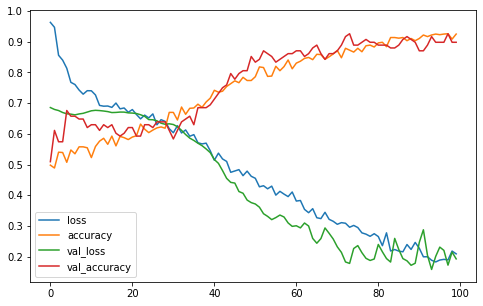

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 25ms/step - loss: 0.9452 - accuracy: 0.5329 - val_loss: 0.6920 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8492 - accuracy: 0.5370 - val_loss: 0.6893 - val_accuracy: 0.5463
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8498 - accuracy: 0.5422 - val_loss: 0.6867 - val_accuracy: 0.5648
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7880 - accuracy: 0.5545 - val_loss: 0.6839 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7895 - accuracy: 0.5453 - val_loss: 0.6834 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7766 - accuracy: 0.5144 - val_loss: 0.6821 - val_accuracy: 0.5648
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7583 - accuracy: 0.5329 - val_loss: 0.6831 - val_acc

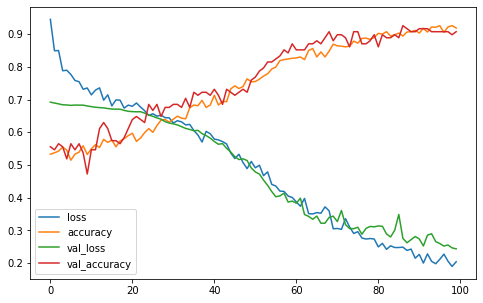

In [40]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9383333325386047
F1_Score  : 0.9371905094455055


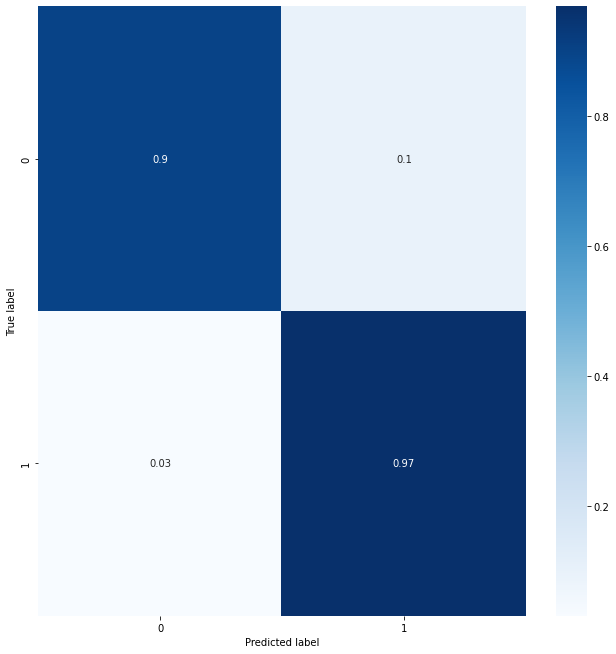

In [41]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [42]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 1.0488 - accuracy: 0.4990 - val_loss: 0.7041 - val_accuracy: 0.4630
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8928 - accuracy: 0.5340 - val_loss: 0.6909 - val_accuracy: 0.5463
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8401 - accuracy: 0.5545 - val_loss: 0.6803 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7970 - accuracy: 0.5545 - val_loss: 0.6598 - val_accuracy: 0.6481
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8156 - accuracy: 0.5556 - val_loss: 0.6443 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7369 - accuracy: 0.5813 - val_loss: 0.6327 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7507 - accuracy: 0.5597 - val_loss: 0.6182 - val_accuracy: 

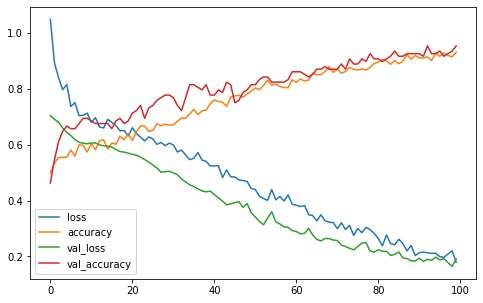

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9716 - accuracy: 0.5453 - val_loss: 0.7510 - val_accuracy: 0.3333
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8723 - accuracy: 0.5319 - val_loss: 0.7234 - val_accuracy: 0.4259
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8190 - accuracy: 0.5525 - val_loss: 0.6966 - val_accuracy: 0.5370
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7990 - accuracy: 0.5340 - val_loss: 0.6829 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7962 - accuracy: 0.5535 - val_loss: 0.6791 - val_accuracy: 0.5833
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7592 - accuracy: 0.5442 - val_loss: 0.6793 - val_accuracy: 0.6204
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7076 - accuracy: 0.5844 - val_loss: 0.6793 - val_accuracy: 

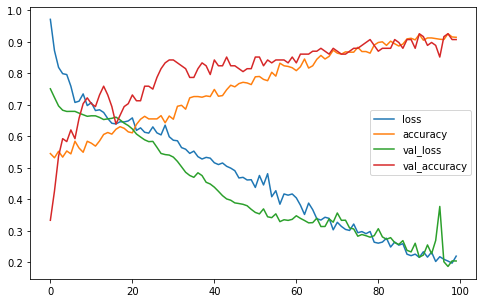

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 24ms/step - loss: 0.9777 - accuracy: 0.5000 - val_loss: 0.6891 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8782 - accuracy: 0.5484 - val_loss: 0.6937 - val_accuracy: 0.4907
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7884 - accuracy: 0.5885 - val_loss: 0.6860 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7307 - accuracy: 0.5916 - val_loss: 0.6815 - val_accuracy: 0.5463
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7628 - accuracy: 0.5823 - val_loss: 0.6755 - val_accuracy: 0.5926
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7083 - accuracy: 0.6080 - val_loss: 0.6791 - val_accuracy: 0.5648
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7410 - accuracy: 0.5936 - val_loss: 0.6835 - val_accuracy

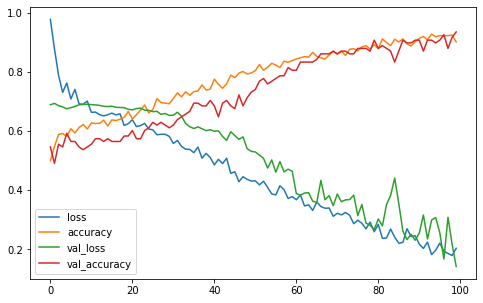

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 1.0119 - accuracy: 0.4979 - val_loss: 0.6947 - val_accuracy: 0.4907
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8315 - accuracy: 0.5638 - val_loss: 0.7020 - val_accuracy: 0.4722
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7976 - accuracy: 0.5895 - val_loss: 0.6924 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7733 - accuracy: 0.5741 - val_loss: 0.6867 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7803 - accuracy: 0.5988 - val_loss: 0.6685 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7478 - accuracy: 0.6029 - val_loss: 0.6643 - val_accuracy: 0.6481
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7531 - accuracy: 0.5885 - val_loss: 0.6669 - val_accuracy:

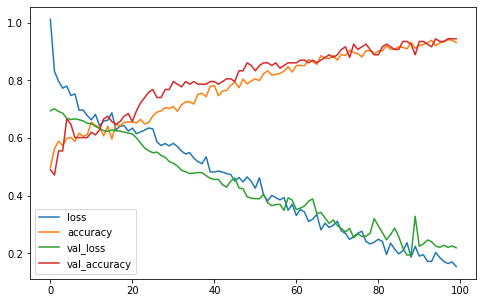

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9951 - accuracy: 0.5638 - val_loss: 0.7189 - val_accuracy: 0.4167
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9210 - accuracy: 0.5144 - val_loss: 0.7313 - val_accuracy: 0.4074
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8257 - accuracy: 0.5586 - val_loss: 0.7167 - val_accuracy: 0.4537
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8048 - accuracy: 0.5823 - val_loss: 0.7010 - val_accuracy: 0.4722
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7136 - accuracy: 0.5864 - val_loss: 0.6863 - val_accuracy: 0.4815
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7765 - accuracy: 0.5617 - val_loss: 0.6679 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7212 - accuracy: 0.5772 - val_loss: 0.6537 - val_accuracy

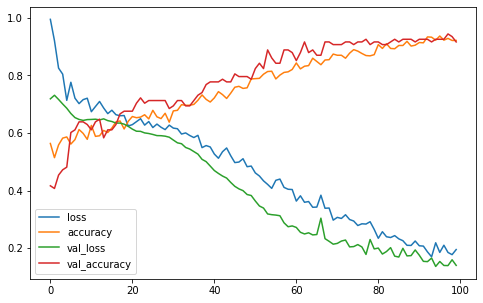

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9758 - accuracy: 0.4959 - val_loss: 0.7168 - val_accuracy: 0.3889
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8275 - accuracy: 0.5586 - val_loss: 0.7005 - val_accuracy: 0.4074
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8034 - accuracy: 0.5710 - val_loss: 0.6871 - val_accuracy: 0.4815
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7521 - accuracy: 0.5782 - val_loss: 0.6817 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7296 - accuracy: 0.5813 - val_loss: 0.6759 - val_accuracy: 0.6574
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7306 - accuracy: 0.5658 - val_loss: 0.6705 - val_accuracy: 0.6481
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7377 - accuracy: 0.5545 - val_loss: 0.6666 - val_accurac

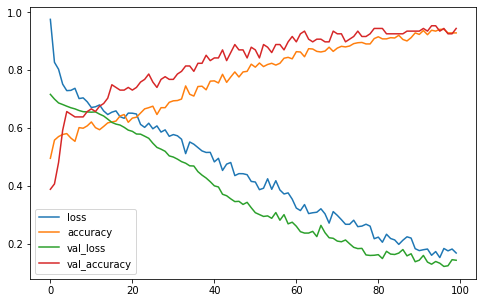

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9637 - accuracy: 0.4835 - val_loss: 0.7250 - val_accuracy: 0.3981
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9240 - accuracy: 0.5103 - val_loss: 0.7157 - val_accuracy: 0.3981
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8327 - accuracy: 0.5257 - val_loss: 0.7043 - val_accuracy: 0.5000
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8370 - accuracy: 0.5123 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7565 - accuracy: 0.5453 - val_loss: 0.6797 - val_accuracy: 0.5833
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7469 - accuracy: 0.5730 - val_loss: 0.6744 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7138 - accuracy: 0.5936 - val_loss: 0.6631 - val_accuracy:

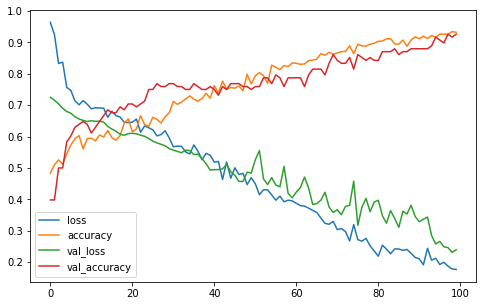

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.8759 - accuracy: 0.5545 - val_loss: 0.7395 - val_accuracy: 0.3889
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8292 - accuracy: 0.5669 - val_loss: 0.7513 - val_accuracy: 0.3796
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8077 - accuracy: 0.5545 - val_loss: 0.7159 - val_accuracy: 0.4444
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7262 - accuracy: 0.5628 - val_loss: 0.7023 - val_accuracy: 0.4630
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7451 - accuracy: 0.5741 - val_loss: 0.6913 - val_accuracy: 0.5833
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6956 - accuracy: 0.5802 - val_loss: 0.6773 - val_accuracy: 0.5833
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6997 - accuracy: 0.6193 - val_loss: 0.6699 - val_accur

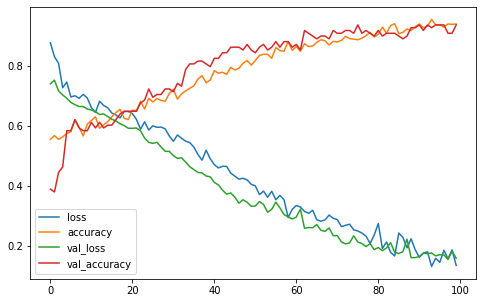

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 26ms/step - loss: 1.0698 - accuracy: 0.4990 - val_loss: 0.6991 - val_accuracy: 0.5185
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.9638 - accuracy: 0.5309 - val_loss: 0.6643 - val_accuracy: 0.5926
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.9590 - accuracy: 0.5340 - val_loss: 0.6493 - val_accuracy: 0.6667
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8444 - accuracy: 0.5576 - val_loss: 0.6408 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7922 - accuracy: 0.5895 - val_loss: 0.6377 - val_accuracy: 0.6944
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7854 - accuracy: 0.5730 - val_loss: 0.6358 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7747 - accuracy: 0.5628 - val_loss: 0.6285 - val_accur

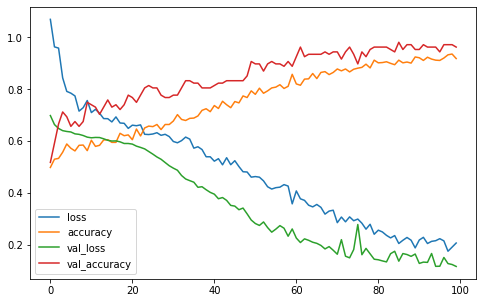

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9052 - accuracy: 0.5000 - val_loss: 0.7035 - val_accuracy: 0.3889
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8154 - accuracy: 0.5442 - val_loss: 0.6956 - val_accuracy: 0.4630
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7986 - accuracy: 0.5525 - val_loss: 0.6766 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7432 - accuracy: 0.5823 - val_loss: 0.6656 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7638 - accuracy: 0.5669 - val_loss: 0.6543 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7511 - accuracy: 0.5874 - val_loss: 0.6540 - val_accuracy: 0.6481
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7069 - accuracy: 0.5844 - val_loss: 0.6511 - val_accu

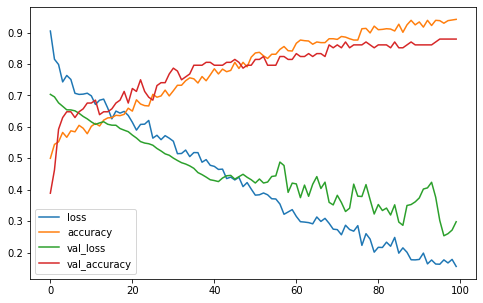

In [43]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9524999856948853
F1_Score  : 0.9397182879896189


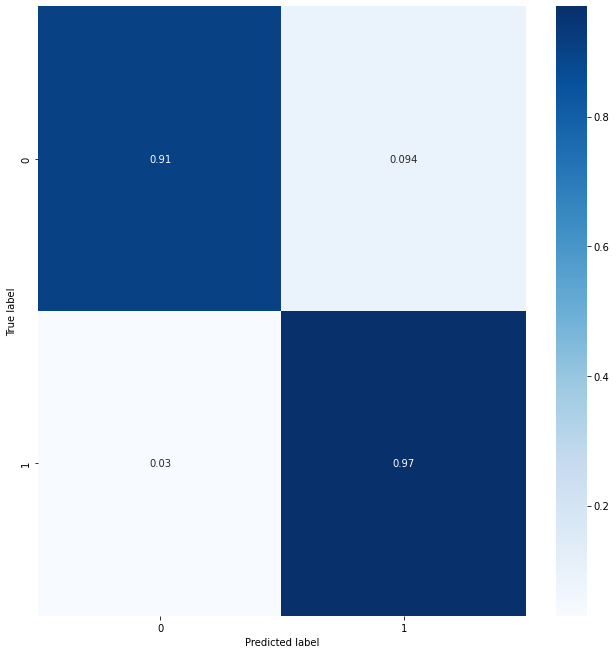

In [44]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 18**

In [45]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(18,19):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.18
(1200, 32, 256, 1)
(1200,) (420,) (780,)
(1200,) (450,) (750,)


3576

# **Valence**

In [46]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8469 - accuracy: 0.5082 - val_loss: 0.6742 - val_accuracy: 0.7130
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7316 - accuracy: 0.5597 - val_loss: 0.6710 - val_accuracy: 0.7315
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6580 - accuracy: 0.6163 - val_loss: 0.6735 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6558 - accuracy: 0.6121 - val_loss: 0.6774 - val_accuracy: 0.4630
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6620 - accuracy: 0.6245 - val_loss: 0.6863 - val_accuracy: 0.4352
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6049 - accuracy: 0.6451 - val_loss: 0.7025 - val_accuracy: 0.4167
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5678 - accuracy: 0.6862 - val_loss: 0.7127 - val_accuracy: 

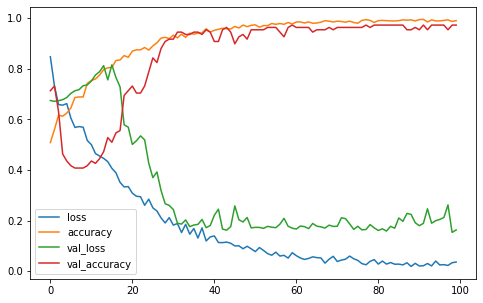

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9002 - accuracy: 0.5535 - val_loss: 0.6755 - val_accuracy: 0.6389
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7744 - accuracy: 0.5957 - val_loss: 0.6711 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7214 - accuracy: 0.6049 - val_loss: 0.6637 - val_accuracy: 0.5370
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6839 - accuracy: 0.6245 - val_loss: 0.6659 - val_accuracy: 0.4907
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6353 - accuracy: 0.6451 - val_loss: 0.6761 - val_accuracy: 0.4722
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6202 - accuracy: 0.6852 - val_loss: 0.6836 - val_accuracy: 0.4722
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6093 - accuracy: 0.6842 - val_loss: 0.7089 - val_accuracy: 

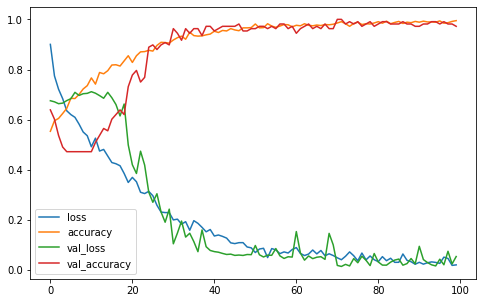

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9193 - accuracy: 0.4506 - val_loss: 0.6854 - val_accuracy: 0.6296
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7996 - accuracy: 0.5309 - val_loss: 0.6816 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7091 - accuracy: 0.5813 - val_loss: 0.6832 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6592 - accuracy: 0.6039 - val_loss: 0.6898 - val_accuracy: 0.5000
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6836 - accuracy: 0.6183 - val_loss: 0.7018 - val_accuracy: 0.4352
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6455 - accuracy: 0.6512 - val_loss: 0.7273 - val_accuracy: 0.4352
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5912 - accuracy: 0.6852 - val_loss: 0.7656 - val_accuracy: 

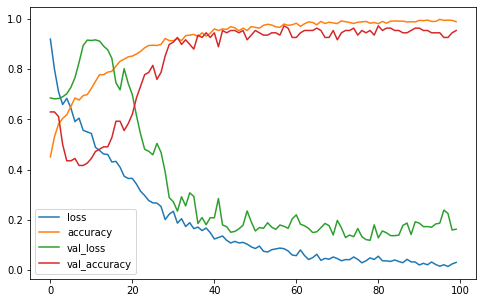

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9260 - accuracy: 0.5226 - val_loss: 0.6770 - val_accuracy: 0.6667
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7776 - accuracy: 0.5607 - val_loss: 0.6793 - val_accuracy: 0.5833
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7226 - accuracy: 0.5864 - val_loss: 0.6793 - val_accuracy: 0.5185
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7121 - accuracy: 0.6039 - val_loss: 0.6827 - val_accuracy: 0.4444
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6394 - accuracy: 0.6430 - val_loss: 0.6916 - val_accuracy: 0.4259
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6776 - accuracy: 0.6214 - val_loss: 0.7017 - val_accuracy: 0.4074
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6574 - accuracy: 0.6276 - val_loss: 0.7076 - val_accuracy: 

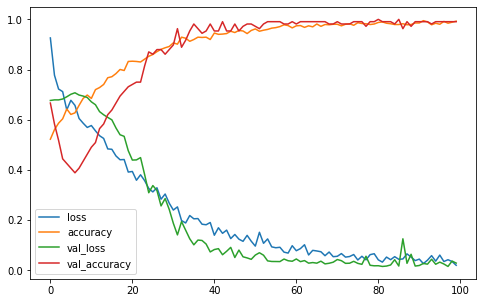

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9411 - accuracy: 0.5010 - val_loss: 0.6692 - val_accuracy: 0.6481
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8176 - accuracy: 0.5679 - val_loss: 0.6655 - val_accuracy: 0.7315
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6815 - accuracy: 0.6173 - val_loss: 0.6658 - val_accuracy: 0.6574
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6838 - accuracy: 0.6286 - val_loss: 0.6698 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6478 - accuracy: 0.6440 - val_loss: 0.6788 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6428 - accuracy: 0.6492 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6070 - accuracy: 0.6811 - val_loss: 0.7279 - val_accura

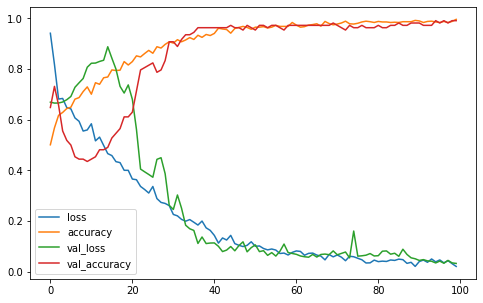

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.9635 - accuracy: 0.5195 - val_loss: 0.6642 - val_accuracy: 0.6574
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8599 - accuracy: 0.5391 - val_loss: 0.6555 - val_accuracy: 0.6481
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7655 - accuracy: 0.5792 - val_loss: 0.6498 - val_accuracy: 0.7037
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.7197 - accuracy: 0.6091 - val_loss: 0.6526 - val_accuracy: 0.5463
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6536 - accuracy: 0.6389 - val_loss: 0.6627 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6750 - accuracy: 0.6276 - val_loss: 0.6682 - val_accuracy: 0.5093
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6486 - accuracy: 0.6502 - val_loss: 0.6764 - val_accu

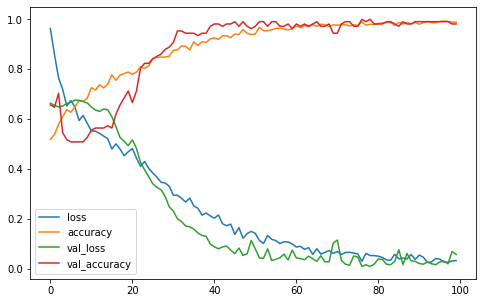

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.8971 - accuracy: 0.5195 - val_loss: 0.6477 - val_accuracy: 0.7407
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.7494 - accuracy: 0.5926 - val_loss: 0.6440 - val_accuracy: 0.7870
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7326 - accuracy: 0.6019 - val_loss: 0.6528 - val_accuracy: 0.6944
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.6992 - accuracy: 0.5782 - val_loss: 0.6563 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6727 - accuracy: 0.6245 - val_loss: 0.6530 - val_accuracy: 0.5278
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6188 - accuracy: 0.6368 - val_loss: 0.6580 - val_accuracy: 0.4537
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 0.5647 - accuracy: 0.6944 - val_loss: 0.6635 - val_accu

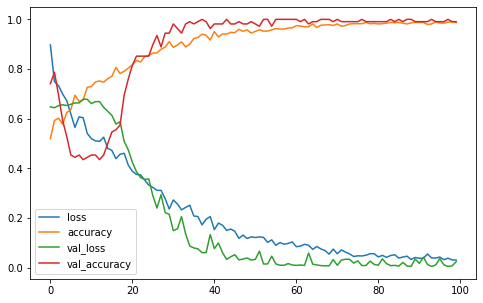

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.9713 - accuracy: 0.4619 - val_loss: 0.6698 - val_accuracy: 0.7130
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8385 - accuracy: 0.5576 - val_loss: 0.6535 - val_accuracy: 0.6944
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7451 - accuracy: 0.6029 - val_loss: 0.6568 - val_accuracy: 0.7407
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.7134 - accuracy: 0.5844 - val_loss: 0.6632 - val_accuracy: 0.5648
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6863 - accuracy: 0.6152 - val_loss: 0.6684 - val_accuracy: 0.5278
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6096 - accuracy: 0.6553 - val_loss: 0.6824 - val_accuracy: 0.4630
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6019 - accuracy: 0.6512 - val_loss: 0.7041 - val_accu

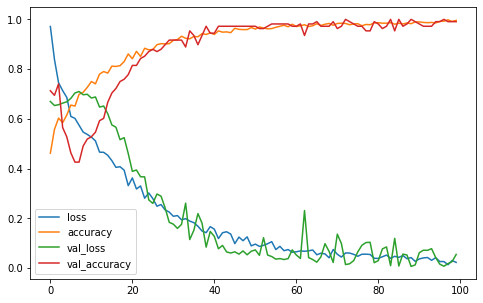

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 26ms/step - loss: 0.9167 - accuracy: 0.5123 - val_loss: 0.6686 - val_accuracy: 0.6667
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7942 - accuracy: 0.5401 - val_loss: 0.6786 - val_accuracy: 0.5093
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7121 - accuracy: 0.6070 - val_loss: 0.6861 - val_accuracy: 0.4537
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6685 - accuracy: 0.6142 - val_loss: 0.6901 - val_accuracy: 0.4352
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6499 - accuracy: 0.6255 - val_loss: 0.7062 - val_accuracy: 0.3981
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6079 - accuracy: 0.6584 - val_loss: 0.7218 - val_accuracy: 0.3981
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6036 - accuracy: 0.6512 - val_loss: 0.7530 - val_accu

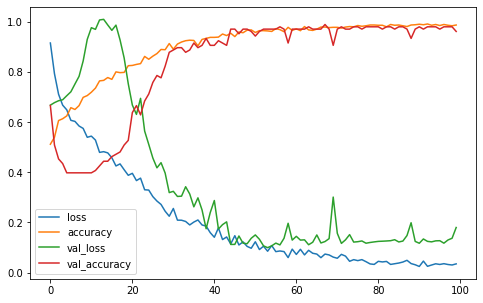

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 26ms/step - loss: 0.9692 - accuracy: 0.5442 - val_loss: 0.6676 - val_accuracy: 0.6852
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8045 - accuracy: 0.5905 - val_loss: 0.6615 - val_accuracy: 0.7037
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7880 - accuracy: 0.5700 - val_loss: 0.6668 - val_accuracy: 0.5278
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.7171 - accuracy: 0.6142 - val_loss: 0.7201 - val_accuracy: 0.4167
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6972 - accuracy: 0.6245 - val_loss: 0.7928 - val_accuracy: 0.4074
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6444 - accuracy: 0.6677 - val_loss: 0.8479 - val_accuracy: 0.3981
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6180 - accuracy: 0.6698 - val_loss: 0.8848 - val_acc

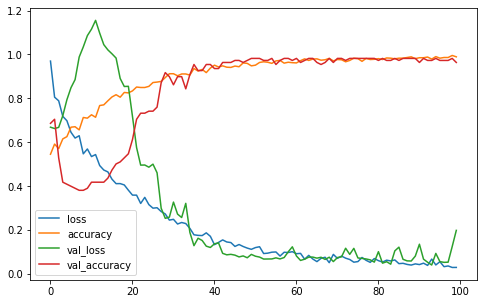

In [47]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9708333313465118
F1_Score  : 0.9700008862196328


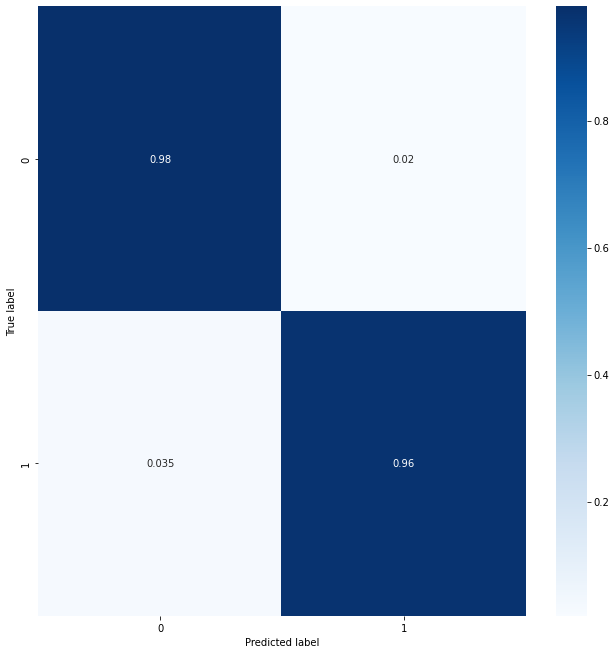

In [48]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [49]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 26ms/step - loss: 0.9281 - accuracy: 0.5165 - val_loss: 0.6732 - val_accuracy: 0.7407
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8196 - accuracy: 0.5319 - val_loss: 0.6612 - val_accuracy: 0.6944
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7824 - accuracy: 0.5473 - val_loss: 0.6623 - val_accuracy: 0.6944
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7434 - accuracy: 0.5463 - val_loss: 0.6644 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6965 - accuracy: 0.5792 - val_loss: 0.6602 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6957 - accuracy: 0.5998 - val_loss: 0.6590 - val_accuracy: 0.7130
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6837 - accuracy: 0.6070 - val_loss: 0.6589 - val_accu

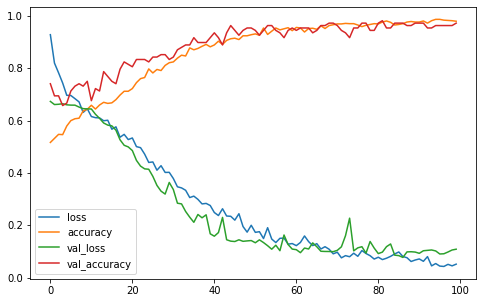

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.9323 - accuracy: 0.5123 - val_loss: 0.6813 - val_accuracy: 0.6481
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8472 - accuracy: 0.5340 - val_loss: 0.6827 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8256 - accuracy: 0.5309 - val_loss: 0.6863 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7184 - accuracy: 0.5813 - val_loss: 0.6849 - val_accuracy: 0.5093
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7373 - accuracy: 0.5751 - val_loss: 0.6882 - val_accuracy: 0.4444
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7002 - accuracy: 0.5864 - val_loss: 0.6905 - val_accuracy: 0.4444
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6765 - accuracy: 0.6296 - val_loss: 0.6952 - val_accu

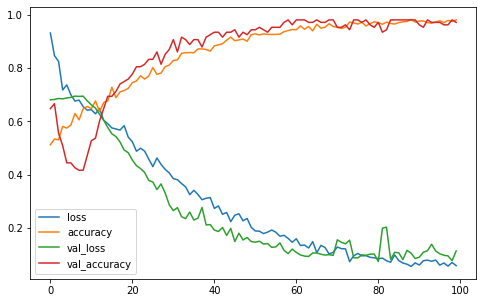

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 26ms/step - loss: 1.0635 - accuracy: 0.4928 - val_loss: 0.6829 - val_accuracy: 0.6296
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8223 - accuracy: 0.5700 - val_loss: 0.6796 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8378 - accuracy: 0.5370 - val_loss: 0.6854 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7592 - accuracy: 0.5720 - val_loss: 0.6864 - val_accuracy: 0.5278
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7433 - accuracy: 0.5802 - val_loss: 0.6865 - val_accuracy: 0.5000
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7109 - accuracy: 0.6060 - val_loss: 0.6875 - val_accuracy: 0.5000
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6899 - accuracy: 0.6337 - val_loss: 0.6920 - val_accu

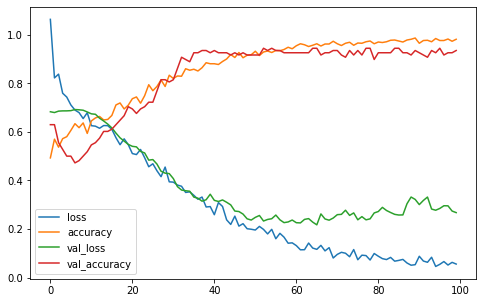

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 28ms/step - loss: 0.9819 - accuracy: 0.5103 - val_loss: 0.6654 - val_accuracy: 0.6759
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8443 - accuracy: 0.5432 - val_loss: 0.6878 - val_accuracy: 0.5278
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8427 - accuracy: 0.5216 - val_loss: 0.7024 - val_accuracy: 0.4444
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7364 - accuracy: 0.5772 - val_loss: 0.7076 - val_accuracy: 0.4444
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7629 - accuracy: 0.5432 - val_loss: 0.7099 - val_accuracy: 0.4722
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6890 - accuracy: 0.5844 - val_loss: 0.7131 - val_accuracy: 0.4722
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6957 - accuracy: 0.5977 - val_loss: 0.7135 - val_accu

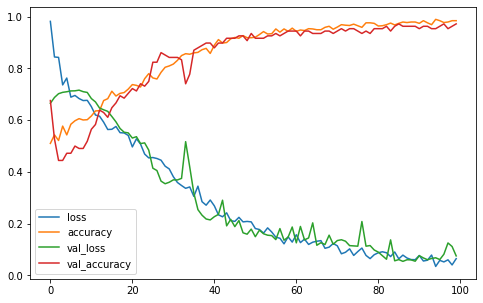

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 26ms/step - loss: 0.9546 - accuracy: 0.5442 - val_loss: 0.6810 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8526 - accuracy: 0.5463 - val_loss: 0.6726 - val_accuracy: 0.6389
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8146 - accuracy: 0.5761 - val_loss: 0.6742 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7863 - accuracy: 0.5720 - val_loss: 0.6784 - val_accuracy: 0.5278
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7276 - accuracy: 0.6132 - val_loss: 0.6725 - val_accuracy: 0.5463
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6837 - accuracy: 0.5998 - val_loss: 0.6618 - val_accuracy: 0.5648
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6819 - accuracy: 0.6327 - val_loss: 0.6533 - val_accu

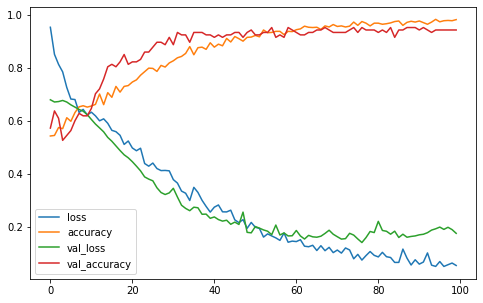

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 26ms/step - loss: 0.9229 - accuracy: 0.4979 - val_loss: 0.6927 - val_accuracy: 0.4815
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8271 - accuracy: 0.5360 - val_loss: 0.6898 - val_accuracy: 0.5648
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.8012 - accuracy: 0.5062 - val_loss: 0.6899 - val_accuracy: 0.5370
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7344 - accuracy: 0.5494 - val_loss: 0.6902 - val_accuracy: 0.5648
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6922 - accuracy: 0.5741 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6924 - accuracy: 0.5689 - val_loss: 0.6890 - val_accuracy: 0.5093
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7099 - accuracy: 0.5617 - val_loss: 0.6850 - val_accu

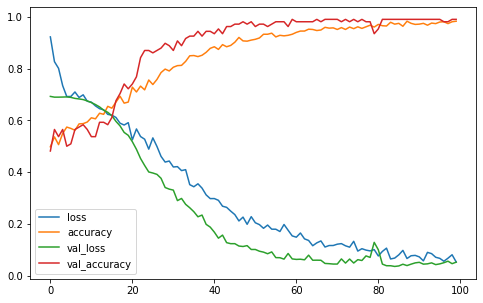

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.9918 - accuracy: 0.4630 - val_loss: 0.6766 - val_accuracy: 0.6111
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8202 - accuracy: 0.5247 - val_loss: 0.6632 - val_accuracy: 0.5926
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7564 - accuracy: 0.5525 - val_loss: 0.6612 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7656 - accuracy: 0.5504 - val_loss: 0.6624 - val_accuracy: 0.7222
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7048 - accuracy: 0.5947 - val_loss: 0.6634 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6754 - accuracy: 0.5947 - val_loss: 0.6637 - val_accuracy: 0.5926
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6715 - accuracy: 0.6204 - val_loss: 0.6602 - val_accu

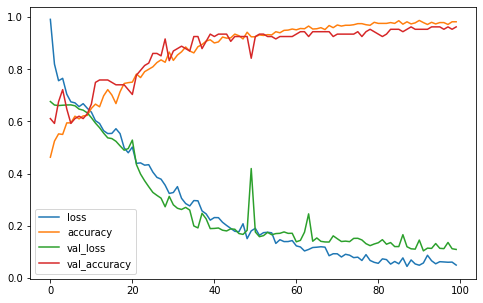

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.9372 - accuracy: 0.5165 - val_loss: 0.6817 - val_accuracy: 0.6852
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8180 - accuracy: 0.5442 - val_loss: 0.6805 - val_accuracy: 0.6944
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7659 - accuracy: 0.5607 - val_loss: 0.6741 - val_accuracy: 0.7593
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7092 - accuracy: 0.6060 - val_loss: 0.6708 - val_accuracy: 0.7870
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6755 - accuracy: 0.6214 - val_loss: 0.6699 - val_accuracy: 0.7500
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 0.6616 - accuracy: 0.6420 - val_loss: 0.6671 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6704 - accuracy: 0.6214 - val_loss: 0.6637 - val_accu

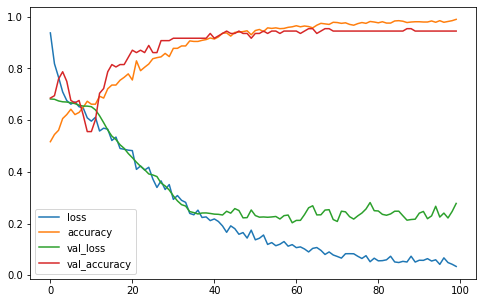

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 28ms/step - loss: 0.9849 - accuracy: 0.4949 - val_loss: 0.6834 - val_accuracy: 0.5648
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.8763 - accuracy: 0.5278 - val_loss: 0.6777 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7603 - accuracy: 0.5813 - val_loss: 0.6778 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7412 - accuracy: 0.5823 - val_loss: 0.6743 - val_accuracy: 0.6204
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7257 - accuracy: 0.5823 - val_loss: 0.6689 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 0.6981 - accuracy: 0.6255 - val_loss: 0.6630 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 0.6660 - accuracy: 0.6337 - val_loss: 0.6601 - val_accu

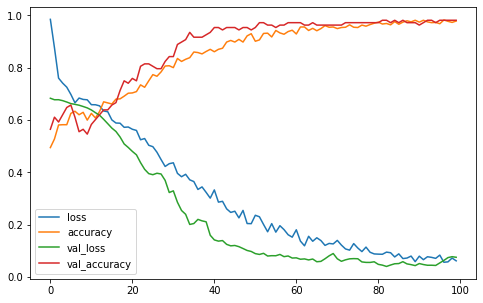

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.9312 - accuracy: 0.5062 - val_loss: 0.6645 - val_accuracy: 0.6852
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7746 - accuracy: 0.5607 - val_loss: 0.6638 - val_accuracy: 0.6852
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7859 - accuracy: 0.5813 - val_loss: 0.6681 - val_accuracy: 0.7222
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7181 - accuracy: 0.6060 - val_loss: 0.6773 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7354 - accuracy: 0.5957 - val_loss: 0.6804 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 0.7261 - accuracy: 0.6080 - val_loss: 0.6853 - val_accuracy: 0.4815
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 0.6705 - accuracy: 0.6245 - val_loss: 0.6937 - val_acc

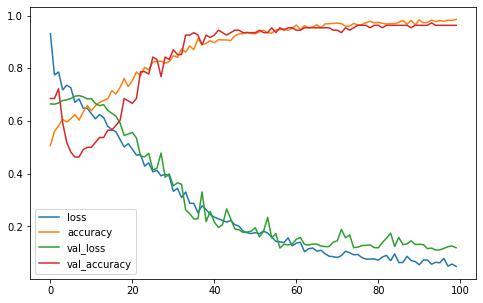

In [50]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9816666722297669
F1_Score  : 0.9808814660873125


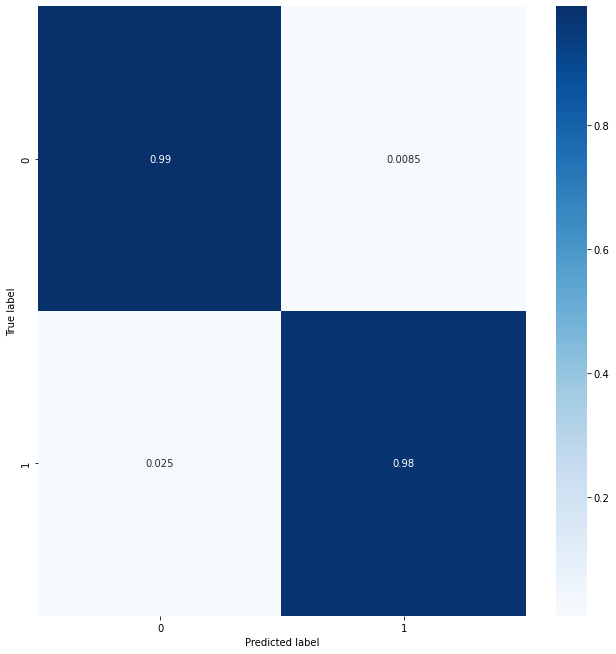

In [51]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()